<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231Nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 113.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=2281f0b63dc5a61aeedb898f19c83b7a5b0d8da4011c3de553d4abde2b2fb48b
  Stored in directory:

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2, data_transforms3

from model_container import ModelContainer



Mounted at /content/gdrive


In [6]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



In [7]:
# train_df = pd.read_pickle('/content/gdrive/MyDrive/train_df.pkl')
# val_df = pd.read_pickle('/content/gdrive/MyDrive/val_df.pkl')
# test_df = pd.read_pickle('/content/gdrive/MyDrive/test_df.pkl')

In [8]:
# Get the data loaders
batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
train_loader3, val_loader3, test_loader3, dataset_sizes3 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms3)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}
dataloaders3 = {'train': train_loader3, 'val': val_loader3, 'test': test_loader3}


In [9]:
# Different combinations to evaluate
models = [CustomResNet50, CustomDenseNet]
loss_funcs = [nn.CrossEntropyLoss, FocalLoss]
loaders = ['dataloaders', 'dataloaders2', 'dataloaders3']
loaders_dict = {'dataloaders': dataloaders, 'dataloaders2': dataloaders2, 'dataloaders3': dataloaders3}
optimizers = ['SGD', 'Adam']
optim_dict = {
    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}



Training with CustomResNet50, dataloaders, SGD, CrossEntropyLoss


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 303MB/s]


Epoch 0/14
----------
train Loss: 2.0162 Acc: 0.4142
val Loss: 1.3122 Acc: 0.6525

Epoch 1/14
----------
train Loss: 0.9388 Acc: 0.7421
val Loss: 0.8272 Acc: 0.7627

Epoch 2/14
----------
train Loss: 0.5695 Acc: 0.8349
val Loss: 0.6956 Acc: 0.7994

Epoch 3/14
----------
train Loss: 0.3677 Acc: 0.8985
val Loss: 0.6211 Acc: 0.8079

Epoch 4/14
----------
train Loss: 0.2358 Acc: 0.9452
val Loss: 0.5830 Acc: 0.8079

Epoch 5/14
----------
train Loss: 0.1547 Acc: 0.9774
val Loss: 0.5776 Acc: 0.8220

Epoch 6/14
----------
train Loss: 0.1015 Acc: 0.9854
val Loss: 0.5494 Acc: 0.8249

Epoch 7/14
----------
train Loss: 0.0697 Acc: 0.9942
val Loss: 0.5784 Acc: 0.8362

Epoch 8/14
----------
train Loss: 0.0732 Acc: 0.9912
val Loss: 0.5885 Acc: 0.8305

Epoch 9/14
----------
train Loss: 0.0659 Acc: 0.9912
val Loss: 0.5550 Acc: 0.8390

Epoch 10/14
----------
train Loss: 0.0693 Acc: 0.9927
val Loss: 0.5731 Acc: 0.8390

Epoch 11/14
----------
train Loss: 0.0644 Acc: 0.9927
val Loss: 0.5655 Acc: 0.8390

Ep

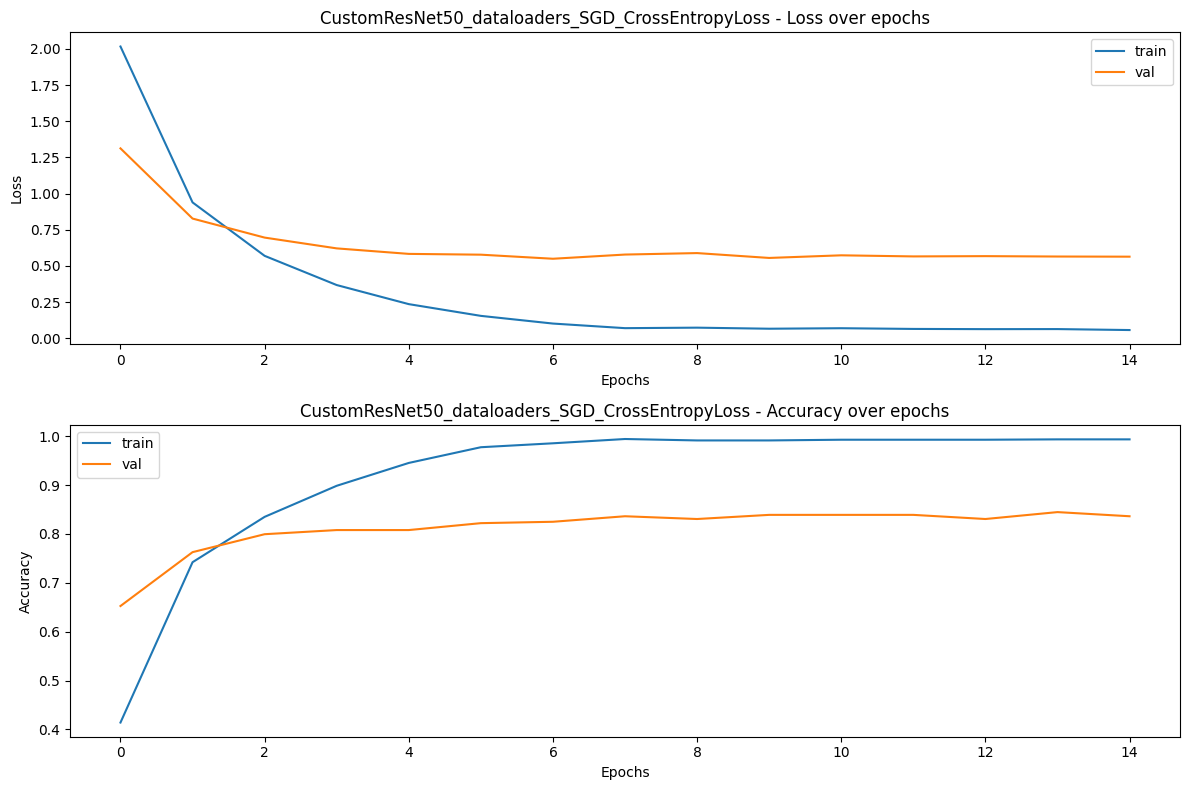


Training with CustomResNet50, dataloaders, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4705 Acc: 0.4522
val Loss: 0.7780 Acc: 0.6582

Epoch 1/14
----------
train Loss: 0.5063 Acc: 0.7838
val Loss: 0.5660 Acc: 0.7260

Epoch 2/14
----------
train Loss: 0.2790 Acc: 0.8576
val Loss: 0.4417 Acc: 0.7825

Epoch 3/14
----------
train Loss: 0.1547 Acc: 0.9240
val Loss: 0.4037 Acc: 0.7994

Epoch 4/14
----------
train Loss: 0.1152 Acc: 0.9321
val Loss: 0.4158 Acc: 0.7910

Epoch 5/14
----------
train Loss: 0.0668 Acc: 0.9686
val Loss: 0.3865 Acc: 0.8079

Epoch 6/14
----------
train Loss: 0.0454 Acc: 0.9832
val Loss: 0.3881 Acc: 0.8164

Epoch 7/14
----------
train Loss: 0.0316 Acc: 0.9920
val Loss: 0.3861 Acc: 0.8136

Epoch 8/14
----------
train Loss: 0.0322 Acc: 0.9934
val Loss: 0.4072 Acc: 0.8136

Epoch 9/14
----------
train Loss: 0.0329 Acc: 0.9934
val Loss: 0.3919 Acc: 0.8136

Epoch 10/14
----------
train Loss: 0.0284 Acc: 0.9934
val Loss: 0.3898 Acc: 0.8220

Epoch 11/14
----------
trai

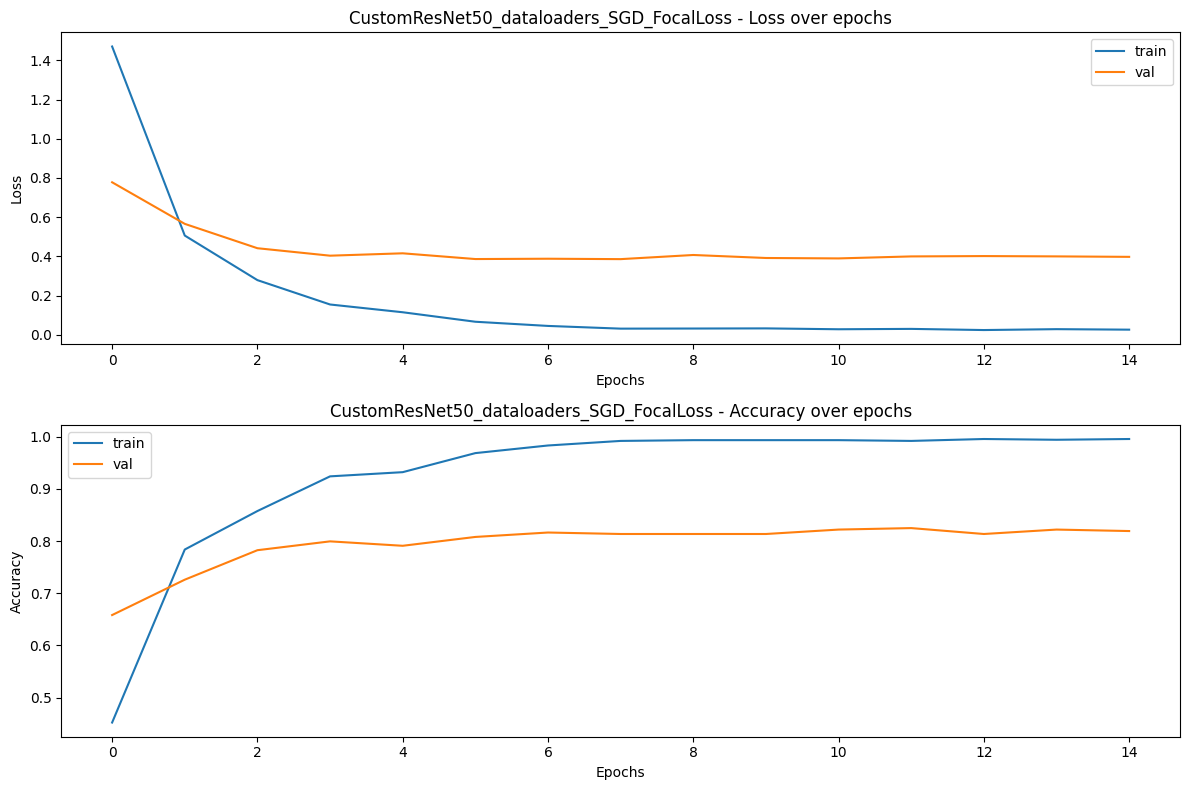


Training with CustomResNet50, dataloaders, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.7756 Acc: 0.4324
val Loss: 2.2317 Acc: 0.4266

Epoch 1/14
----------
train Loss: 1.2513 Acc: 0.5771
val Loss: 1.5454 Acc: 0.5395

Epoch 2/14
----------
train Loss: 1.1194 Acc: 0.6216
val Loss: 2.4312 Acc: 0.4576

Epoch 3/14
----------
train Loss: 1.0407 Acc: 0.6545
val Loss: 1.3160 Acc: 0.5706

Epoch 4/14
----------
train Loss: 0.8992 Acc: 0.7107
val Loss: 1.6089 Acc: 0.5734

Epoch 5/14
----------
train Loss: 0.8270 Acc: 0.7253
val Loss: 1.7868 Acc: 0.5424

Epoch 6/14
----------
train Loss: 0.6746 Acc: 0.7626
val Loss: 1.2498 Acc: 0.6921

Epoch 7/14
----------
train Loss: 0.4689 Acc: 0.8393
val Loss: 0.8000 Acc: 0.7458

Epoch 8/14
----------
train Loss: 0.3417 Acc: 0.8897
val Loss: 0.7388 Acc: 0.7486

Epoch 9/14
----------
train Loss: 0.3152 Acc: 0.8955
val Loss: 0.7612 Acc: 0.7627

Epoch 10/14
----------
train Loss: 0.2447 Acc: 0.9182
val Loss: 0.6819 Acc: 0.7514

Epoch 11/14
-------

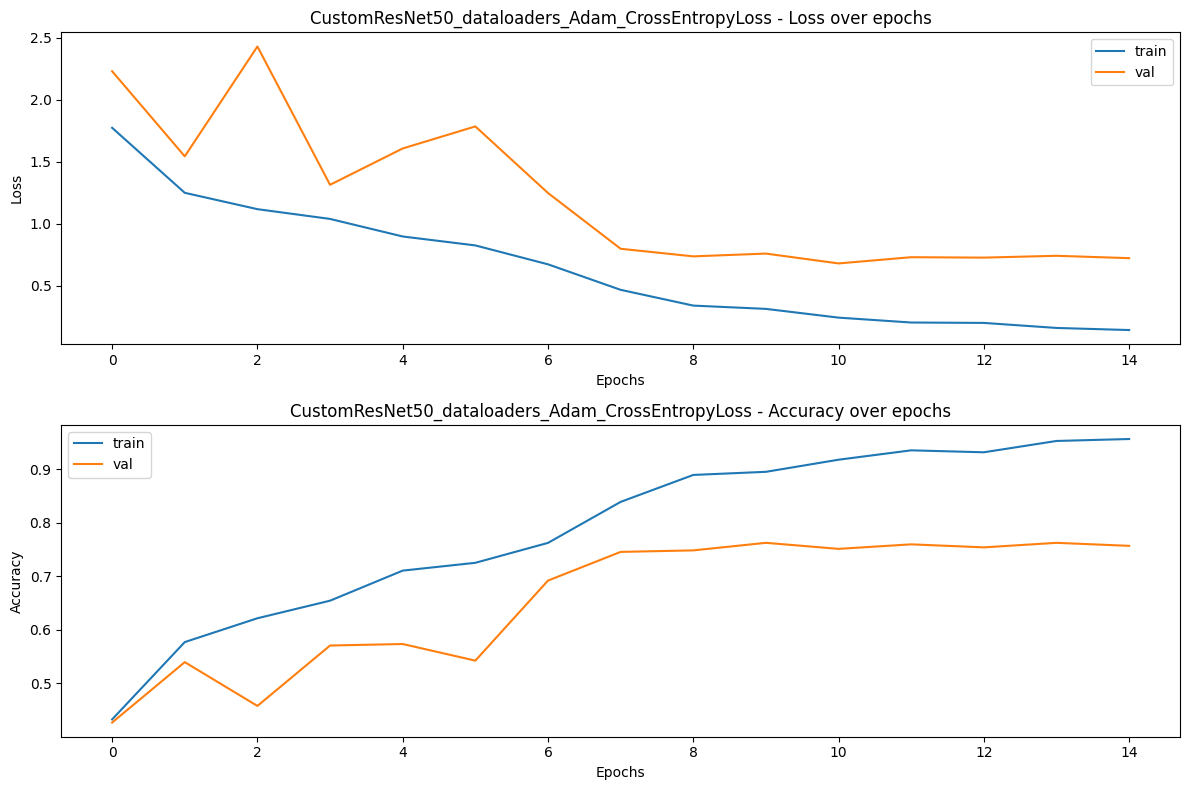


Training with CustomResNet50, dataloaders, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.3243 Acc: 0.4492
val Loss: 1.5573 Acc: 0.4011

Epoch 1/14
----------
train Loss: 0.8676 Acc: 0.5610
val Loss: 1.2215 Acc: 0.4972

Epoch 2/14
----------
train Loss: 0.6670 Acc: 0.6508
val Loss: 1.5294 Acc: 0.4407

Epoch 3/14
----------
train Loss: 0.5390 Acc: 0.6961
val Loss: 1.0821 Acc: 0.5763

Epoch 4/14
----------
train Loss: 0.4122 Acc: 0.7655
val Loss: 1.0570 Acc: 0.5282

Epoch 5/14
----------
train Loss: 0.3893 Acc: 0.7692
val Loss: 0.8803 Acc: 0.6130

Epoch 6/14
----------
train Loss: 0.3365 Acc: 0.8006
val Loss: 0.5474 Acc: 0.7147

Epoch 7/14
----------
train Loss: 0.1521 Acc: 0.9014
val Loss: 0.4201 Acc: 0.7712

Epoch 8/14
----------
train Loss: 0.1001 Acc: 0.9284
val Loss: 0.4101 Acc: 0.7853

Epoch 9/14
----------
train Loss: 0.0821 Acc: 0.9386
val Loss: 0.3932 Acc: 0.7910

Epoch 10/14
----------
train Loss: 0.0784 Acc: 0.9364
val Loss: 0.4446 Acc: 0.7881

Epoch 11/14
----------
tra

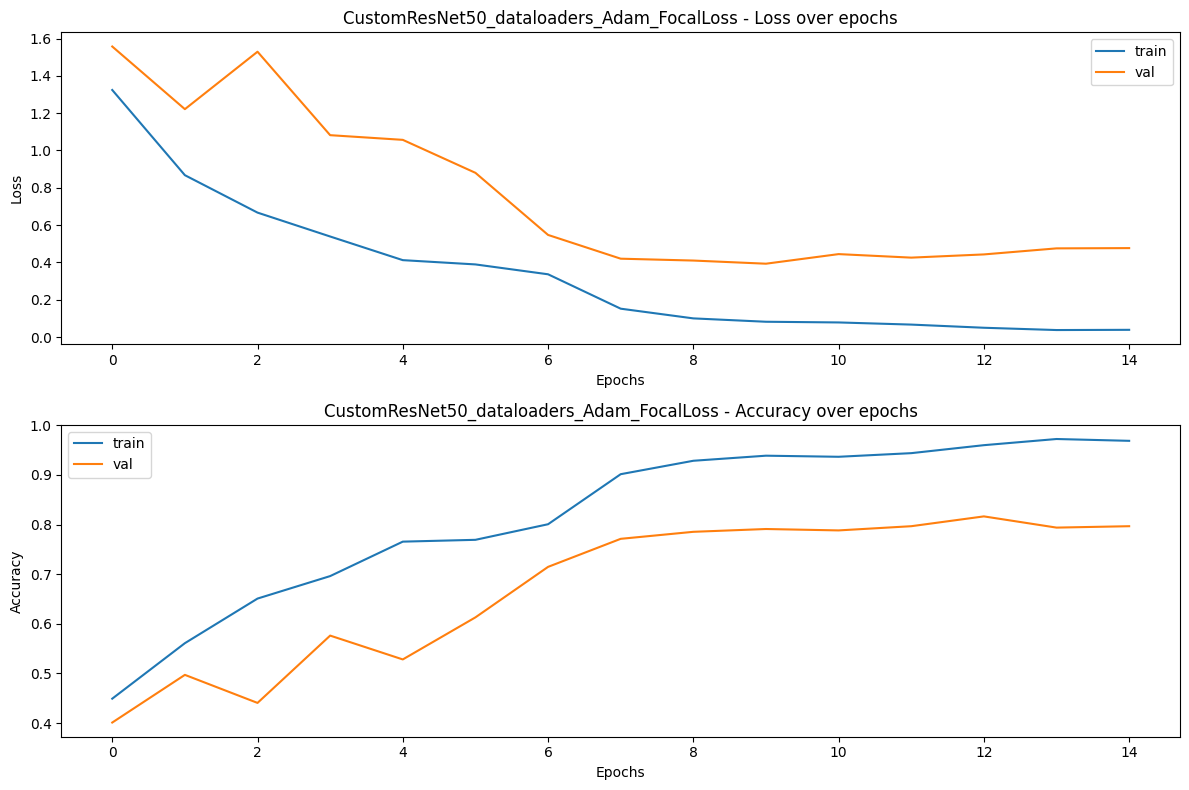


Training with CustomResNet50, dataloaders2, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.0485 Acc: 0.3930
val Loss: 1.3406 Acc: 0.6017

Epoch 1/14
----------
train Loss: 1.0417 Acc: 0.7085
val Loss: 0.8843 Acc: 0.7429

Epoch 2/14
----------
train Loss: 0.6355 Acc: 0.8196
val Loss: 0.6787 Acc: 0.8023

Epoch 3/14
----------
train Loss: 0.4401 Acc: 0.8780
val Loss: 0.6637 Acc: 0.7966

Epoch 4/14
----------
train Loss: 0.3304 Acc: 0.9058
val Loss: 0.6276 Acc: 0.8079

Epoch 5/14
----------
train Loss: 0.2647 Acc: 0.9284
val Loss: 0.6698 Acc: 0.8107

Epoch 6/14
----------
train Loss: 0.2048 Acc: 0.9452
val Loss: 0.5818 Acc: 0.8333

Epoch 7/14
----------
train Loss: 0.1400 Acc: 0.9759
val Loss: 0.5828 Acc: 0.8136

Epoch 8/14
----------
train Loss: 0.1219 Acc: 0.9803
val Loss: 0.5633 Acc: 0.8333

Epoch 9/14
----------
train Loss: 0.1279 Acc: 0.9730
val Loss: 0.5732 Acc: 0.8333

Epoch 10/14
----------
train Loss: 0.1142 Acc: 0.9869
val Loss: 0.5678 Acc: 0.8305

Epoch 11/14
-------

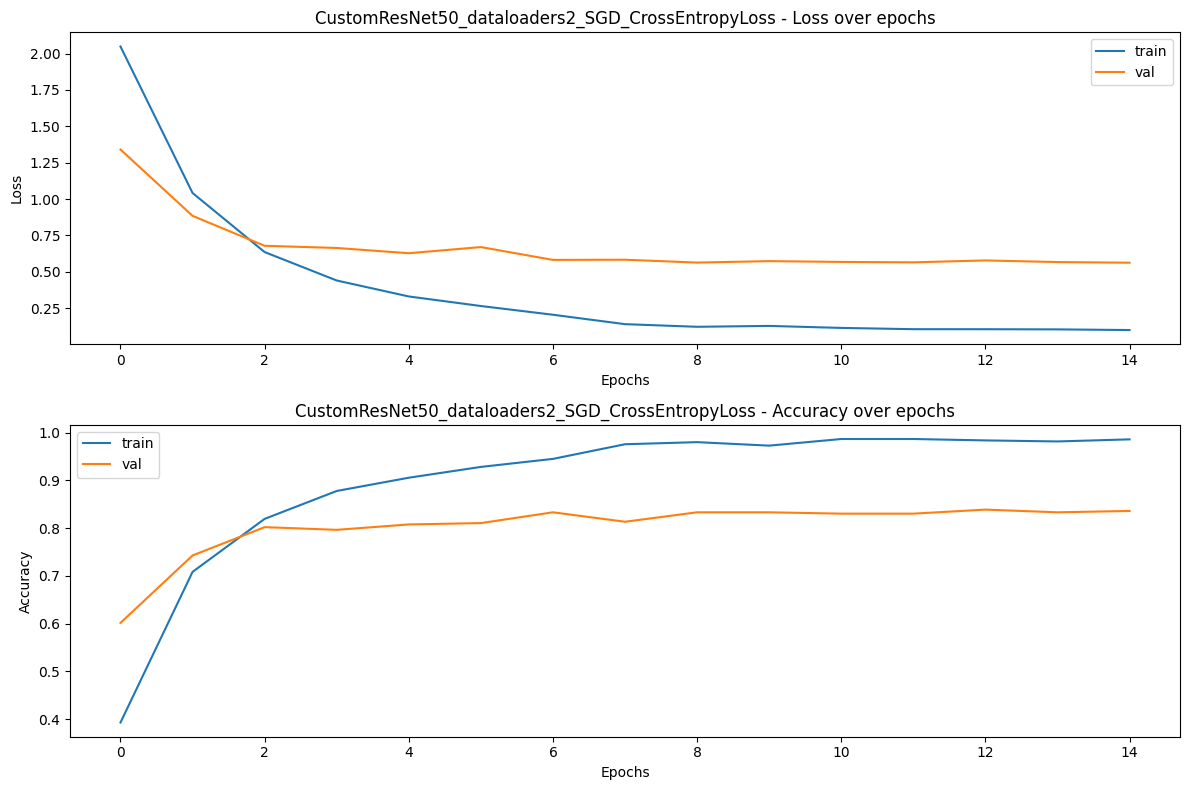


Training with CustomResNet50, dataloaders2, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.5183 Acc: 0.4492
val Loss: 0.8252 Acc: 0.6412

Epoch 1/14
----------
train Loss: 0.5829 Acc: 0.7400
val Loss: 0.6085 Acc: 0.6864

Epoch 2/14
----------
train Loss: 0.3570 Acc: 0.8240
val Loss: 0.5050 Acc: 0.7514

Epoch 3/14
----------
train Loss: 0.2278 Acc: 0.8780
val Loss: 0.4648 Acc: 0.7881

Epoch 4/14
----------
train Loss: 0.1523 Acc: 0.9145
val Loss: 0.4011 Acc: 0.8079

Epoch 5/14
----------
train Loss: 0.1118 Acc: 0.9423
val Loss: 0.4551 Acc: 0.7881

Epoch 6/14
----------
train Loss: 0.0866 Acc: 0.9481
val Loss: 0.3810 Acc: 0.8023

Epoch 7/14
----------
train Loss: 0.0550 Acc: 0.9679
val Loss: 0.3706 Acc: 0.8164

Epoch 8/14
----------
train Loss: 0.0503 Acc: 0.9730
val Loss: 0.3728 Acc: 0.8305

Epoch 9/14
----------
train Loss: 0.0496 Acc: 0.9744
val Loss: 0.3869 Acc: 0.8220

Epoch 10/14
----------
train Loss: 0.0464 Acc: 0.9825
val Loss: 0.3778 Acc: 0.8220

Epoch 11/14
----------
tra

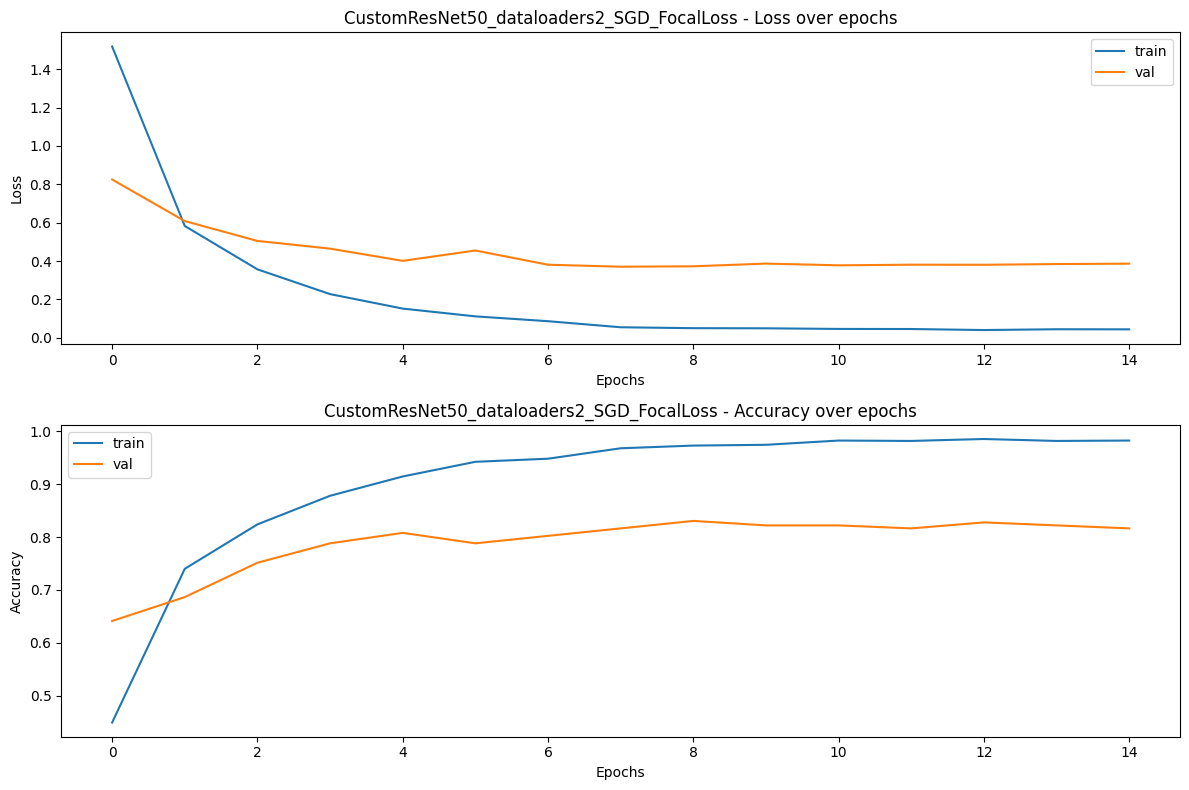


Training with CustomResNet50, dataloaders2, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.0039 Acc: 0.3565
val Loss: 2.0918 Acc: 0.4350

Epoch 1/14
----------
train Loss: 1.4453 Acc: 0.5062
val Loss: 1.5925 Acc: 0.4153

Epoch 2/14
----------
train Loss: 1.2590 Acc: 0.5661
val Loss: 1.1622 Acc: 0.5989

Epoch 3/14
----------
train Loss: 1.0628 Acc: 0.6392
val Loss: 2.1147 Acc: 0.4633

Epoch 4/14
----------
train Loss: 0.9588 Acc: 0.6830
val Loss: 1.1851 Acc: 0.5960

Epoch 5/14
----------
train Loss: 0.8207 Acc: 0.7392
val Loss: 1.6770 Acc: 0.5085

Epoch 6/14
----------
train Loss: 0.7484 Acc: 0.7407
val Loss: 1.1034 Acc: 0.6469

Epoch 7/14
----------
train Loss: 0.5292 Acc: 0.8181
val Loss: 0.8819 Acc: 0.7232

Epoch 8/14
----------
train Loss: 0.4063 Acc: 0.8707
val Loss: 0.8694 Acc: 0.7119

Epoch 9/14
----------
train Loss: 0.3942 Acc: 0.8692
val Loss: 0.8543 Acc: 0.7288

Epoch 10/14
----------
train Loss: 0.3174 Acc: 0.9028
val Loss: 0.7829 Acc: 0.7458

Epoch 11/14
------

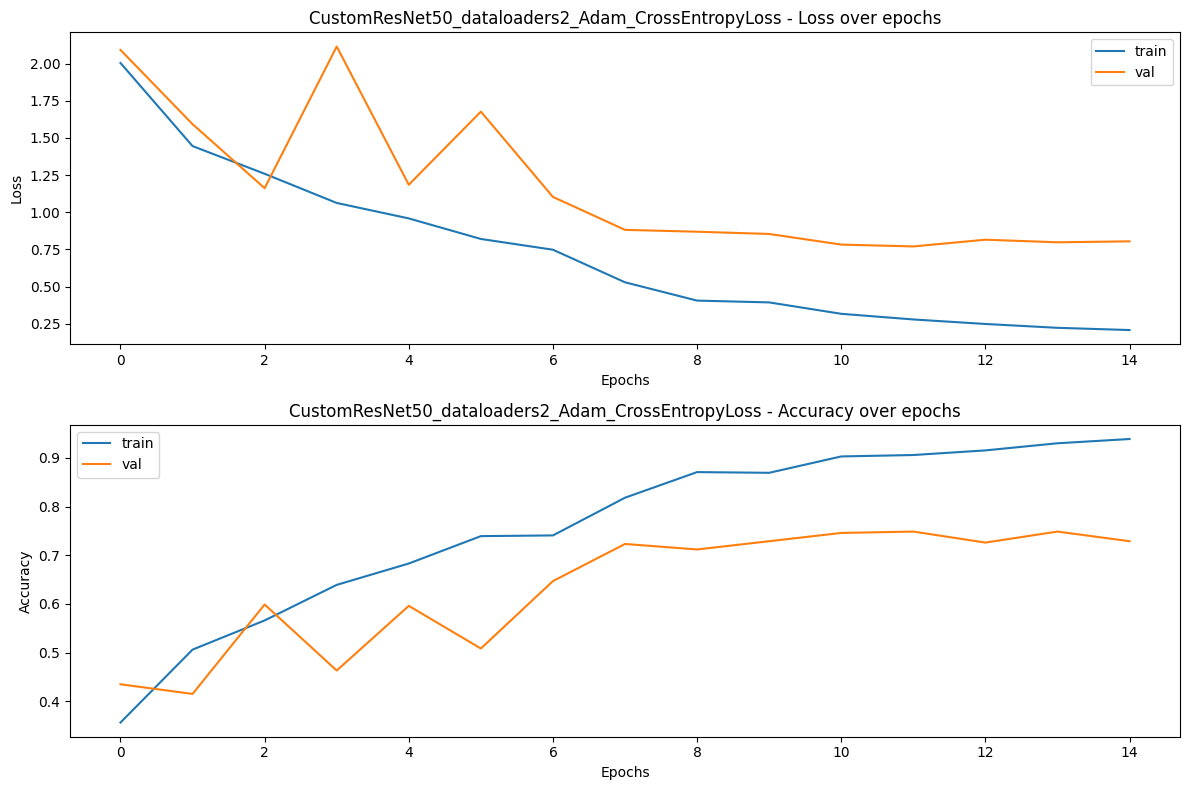


Training with CustomResNet50, dataloaders2, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.4733 Acc: 0.3857
val Loss: 25.4224 Acc: 0.0989

Epoch 1/14
----------
train Loss: 0.9949 Acc: 0.4916
val Loss: 1.2353 Acc: 0.4181

Epoch 2/14
----------
train Loss: 0.8118 Acc: 0.5698
val Loss: 1.1427 Acc: 0.5395

Epoch 3/14
----------
train Loss: 0.7359 Acc: 0.6070
val Loss: 0.9840 Acc: 0.5791

Epoch 4/14
----------
train Loss: 0.6289 Acc: 0.6413
val Loss: 0.8700 Acc: 0.5763

Epoch 5/14
----------
train Loss: 0.5444 Acc: 0.6844
val Loss: 0.9882 Acc: 0.5847

Epoch 6/14
----------
train Loss: 0.4828 Acc: 0.7107
val Loss: 0.8641 Acc: 0.5763

Epoch 7/14
----------
train Loss: 0.3413 Acc: 0.7955
val Loss: 0.6557 Acc: 0.7062

Epoch 8/14
----------
train Loss: 0.2581 Acc: 0.8247
val Loss: 0.6293 Acc: 0.6864

Epoch 9/14
----------
train Loss: 0.2114 Acc: 0.8546
val Loss: 0.6180 Acc: 0.7119

Epoch 10/14
----------
train Loss: 0.2048 Acc: 0.8583
val Loss: 0.6406 Acc: 0.7260

Epoch 11/14
----------
t

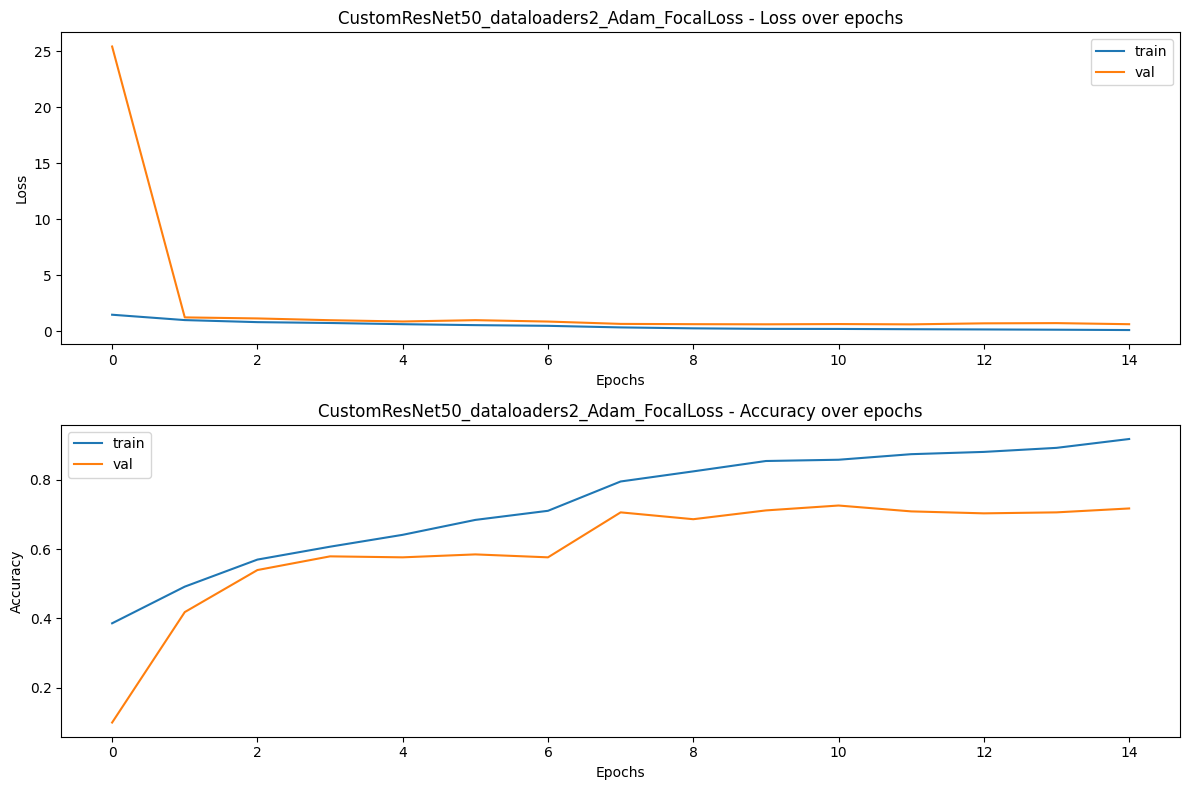


Training with CustomResNet50, dataloaders3, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.1056 Acc: 0.3455
val Loss: 1.3701 Acc: 0.6186

Epoch 1/14
----------
train Loss: 1.0655 Acc: 0.7107
val Loss: 0.9618 Acc: 0.6893

Epoch 2/14
----------
train Loss: 0.6930 Acc: 0.7904
val Loss: 0.7238 Acc: 0.7542

Epoch 3/14
----------
train Loss: 0.4632 Acc: 0.8692
val Loss: 0.6527 Acc: 0.7881

Epoch 4/14
----------
train Loss: 0.3362 Acc: 0.9058
val Loss: 0.7360 Acc: 0.7910

Epoch 5/14
----------
train Loss: 0.2559 Acc: 0.9328
val Loss: 0.6388 Acc: 0.8164

Epoch 6/14
----------
train Loss: 0.2069 Acc: 0.9423
val Loss: 0.6362 Acc: 0.8136

Epoch 7/14
----------
train Loss: 0.1546 Acc: 0.9671
val Loss: 0.6409 Acc: 0.8192

Epoch 8/14
----------
train Loss: 0.1336 Acc: 0.9737
val Loss: 0.6419 Acc: 0.8249

Epoch 9/14
----------
train Loss: 0.1506 Acc: 0.9708
val Loss: 0.6510 Acc: 0.8164

Epoch 10/14
----------
train Loss: 0.1331 Acc: 0.9774
val Loss: 0.6522 Acc: 0.8192

Epoch 11/14
-------

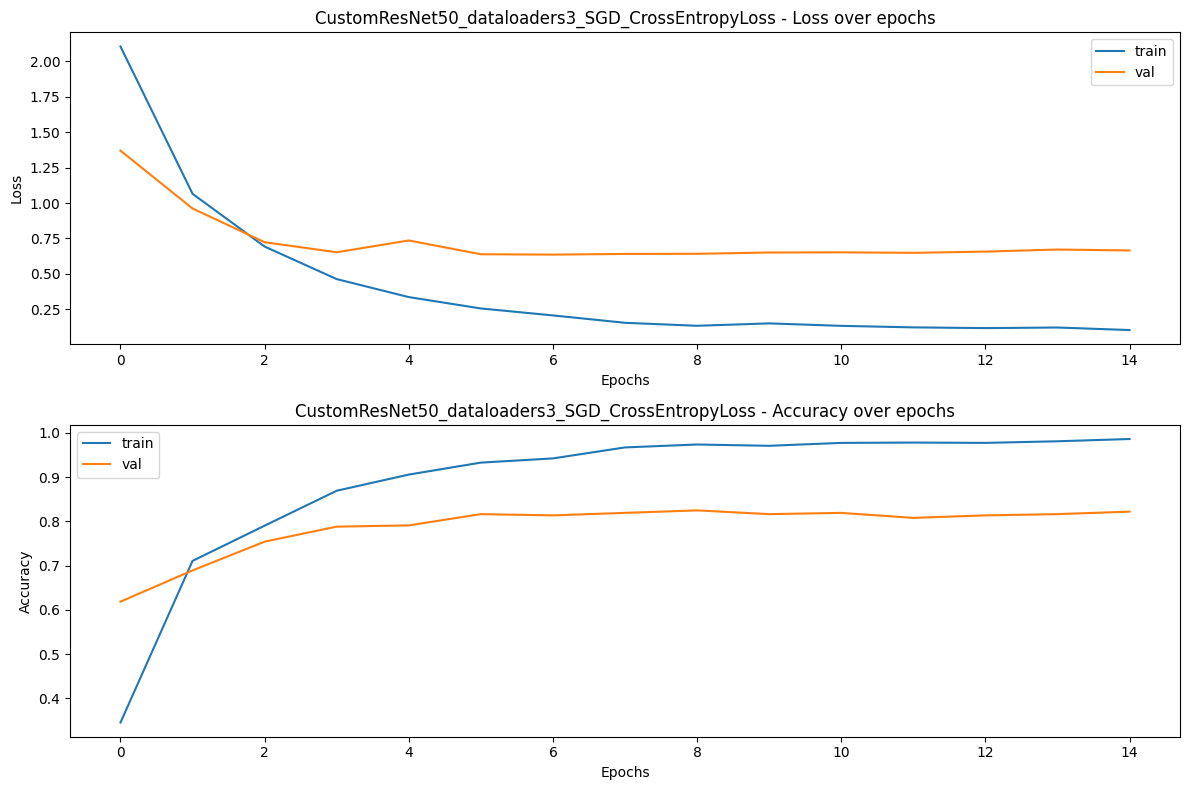


Training with CustomResNet50, dataloaders3, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.5282 Acc: 0.4171
val Loss: 0.8577 Acc: 0.6186

Epoch 1/14
----------
train Loss: 0.6496 Acc: 0.6815
val Loss: 0.6021 Acc: 0.6921

Epoch 2/14
----------
train Loss: 0.3498 Acc: 0.8283
val Loss: 0.4865 Acc: 0.7401

Epoch 3/14
----------
train Loss: 0.2349 Acc: 0.8751
val Loss: 0.4544 Acc: 0.7853

Epoch 4/14
----------
train Loss: 0.1701 Acc: 0.9145
val Loss: 0.4250 Acc: 0.7881

Epoch 5/14
----------
train Loss: 0.1142 Acc: 0.9306
val Loss: 0.3930 Acc: 0.8079

Epoch 6/14
----------
train Loss: 0.0895 Acc: 0.9554
val Loss: 0.4299 Acc: 0.7910

Epoch 7/14
----------
train Loss: 0.0751 Acc: 0.9649
val Loss: 0.3677 Acc: 0.8107

Epoch 8/14
----------
train Loss: 0.0513 Acc: 0.9825
val Loss: 0.3580 Acc: 0.8051

Epoch 9/14
----------
train Loss: 0.0506 Acc: 0.9810
val Loss: 0.3754 Acc: 0.8023

Epoch 10/14
----------
train Loss: 0.0549 Acc: 0.9781
val Loss: 0.3651 Acc: 0.8051

Epoch 11/14
----------
tra

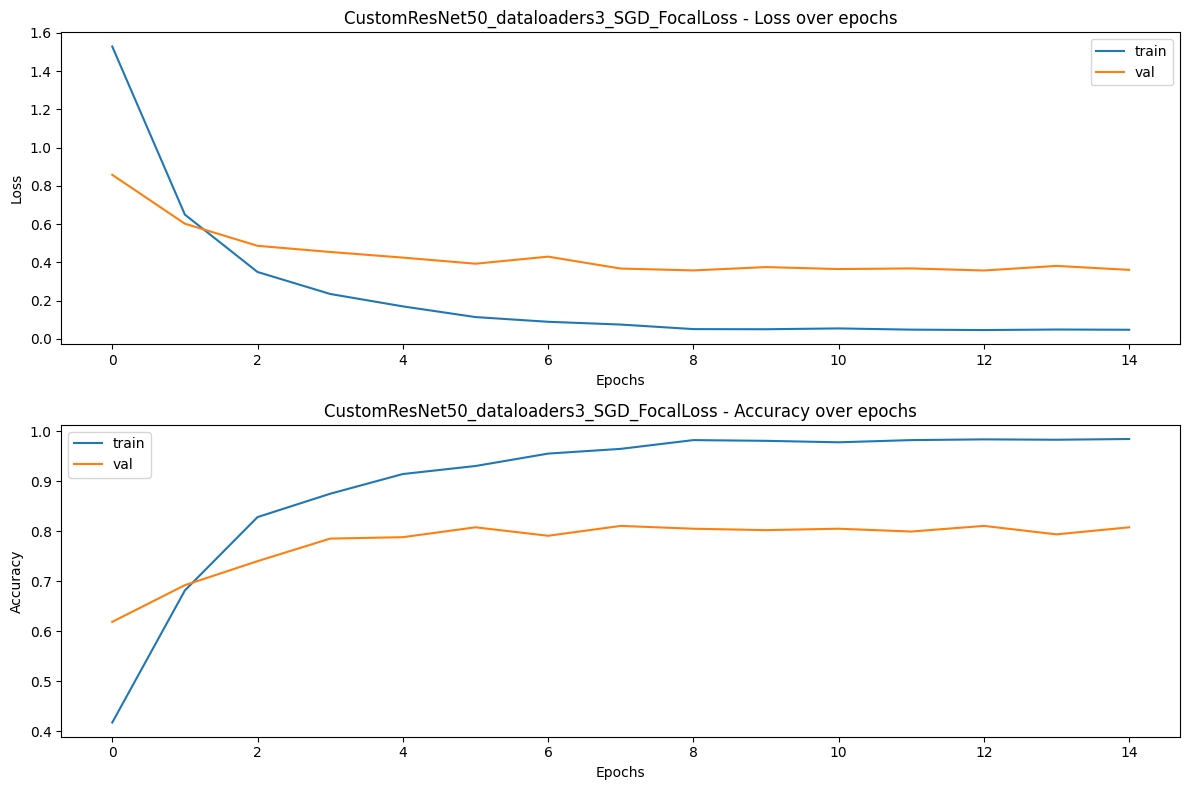


Training with CustomResNet50, dataloaders3, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9209 Acc: 0.3630
val Loss: 2.7216 Acc: 0.2853

Epoch 1/14
----------
train Loss: 1.5245 Acc: 0.4865
val Loss: 1.9010 Acc: 0.3955

Epoch 2/14
----------
train Loss: 1.3239 Acc: 0.5413
val Loss: 1.6019 Acc: 0.4294

Epoch 3/14
----------
train Loss: 1.1687 Acc: 0.6034
val Loss: 1.7820 Acc: 0.4689

Epoch 4/14
----------
train Loss: 1.0638 Acc: 0.6245
val Loss: 1.2680 Acc: 0.6130

Epoch 5/14
----------
train Loss: 0.9755 Acc: 0.6501
val Loss: 1.9714 Acc: 0.4887

Epoch 6/14
----------
train Loss: 0.8825 Acc: 0.7020
val Loss: 1.5607 Acc: 0.5650

Epoch 7/14
----------
train Loss: 0.6957 Acc: 0.7750
val Loss: 0.9538 Acc: 0.6695

Epoch 8/14
----------
train Loss: 0.5717 Acc: 0.8050
val Loss: 0.9259 Acc: 0.6836

Epoch 9/14
----------
train Loss: 0.5278 Acc: 0.8247
val Loss: 0.9614 Acc: 0.6554

Epoch 10/14
----------
train Loss: 0.4729 Acc: 0.8305
val Loss: 0.9370 Acc: 0.6893

Epoch 11/14
------

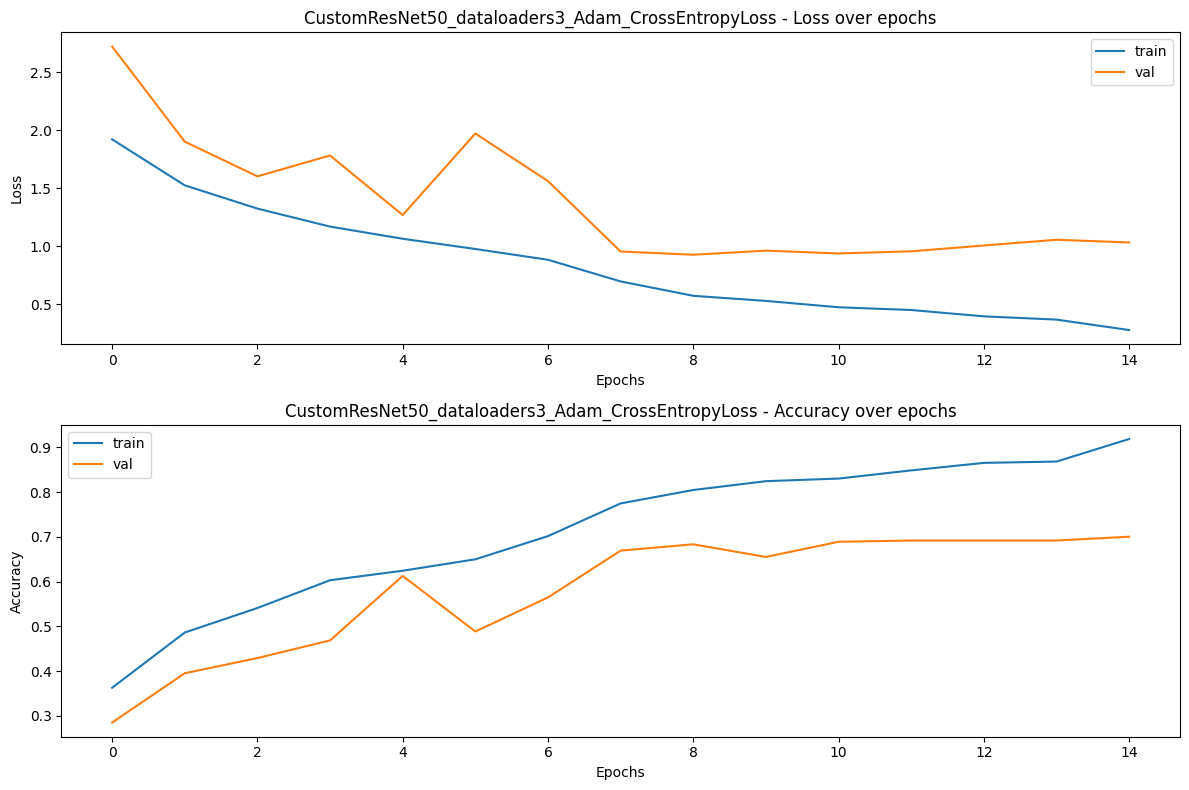


Training with CustomResNet50, dataloaders3, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.6514 Acc: 0.3302
val Loss: 1.4084 Acc: 0.3870

Epoch 1/14
----------
train Loss: 1.0401 Acc: 0.4865
val Loss: 1.2347 Acc: 0.4605

Epoch 2/14
----------
train Loss: 0.8826 Acc: 0.5296
val Loss: 0.9038 Acc: 0.5593

Epoch 3/14
----------
train Loss: 0.7767 Acc: 0.5807
val Loss: 1.0511 Acc: 0.4859

Epoch 4/14
----------
train Loss: 0.6313 Acc: 0.6333
val Loss: 1.0625 Acc: 0.5367

Epoch 5/14
----------
train Loss: 0.5740 Acc: 0.6428
val Loss: 1.2538 Acc: 0.5226

Epoch 6/14
----------
train Loss: 0.5080 Acc: 0.7042
val Loss: 1.0706 Acc: 0.5734

Epoch 7/14
----------
train Loss: 0.3434 Acc: 0.7772
val Loss: 0.6241 Acc: 0.6977

Epoch 8/14
----------
train Loss: 0.2706 Acc: 0.8072
val Loss: 0.6055 Acc: 0.7119

Epoch 9/14
----------
train Loss: 0.2425 Acc: 0.8203
val Loss: 0.6215 Acc: 0.7119

Epoch 10/14
----------
train Loss: 0.2308 Acc: 0.8342
val Loss: 0.6351 Acc: 0.7034

Epoch 11/14
----------
tr

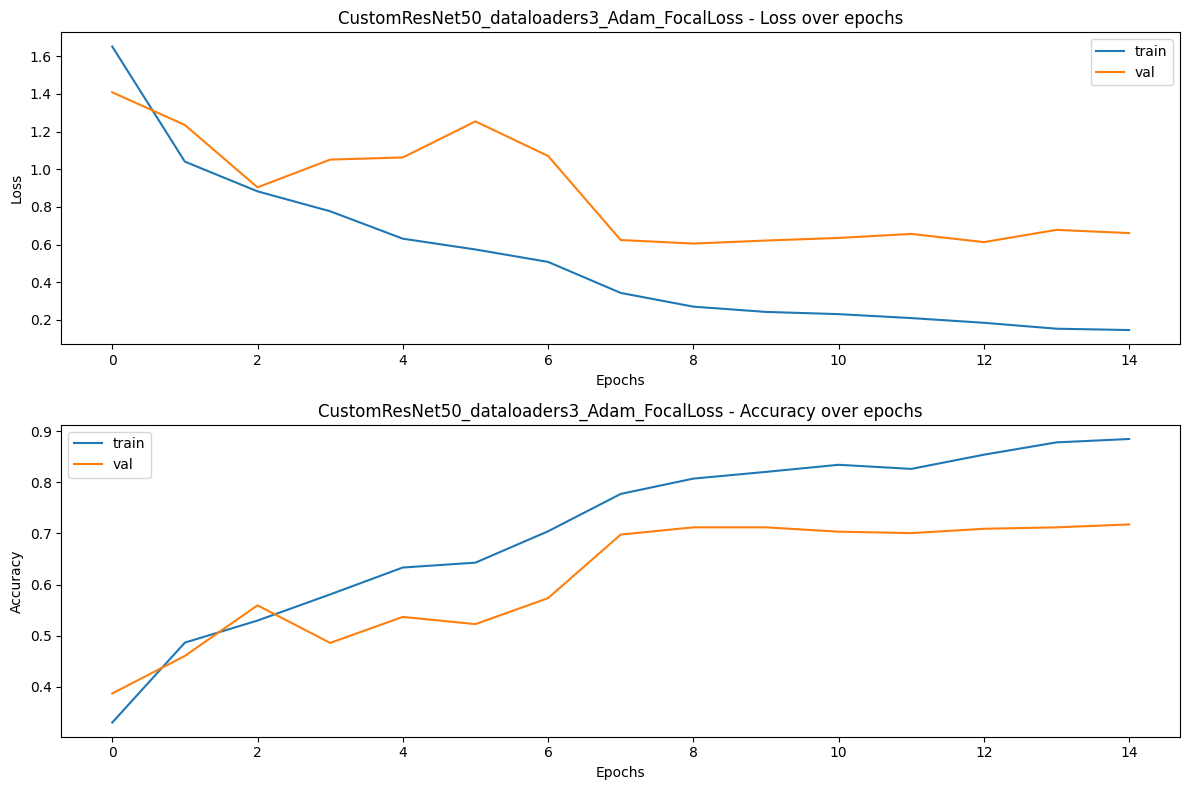

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Training with CustomDenseNet, dataloaders, SGD, CrossEntropyLoss


100%|██████████| 30.8M/30.8M [00:00<00:00, 67.0MB/s]


Epoch 0/14
----------
train Loss: 1.8536 Acc: 0.4500
val Loss: 1.1863 Acc: 0.6836

Epoch 1/14
----------
train Loss: 0.8615 Acc: 0.7714
val Loss: 0.7886 Acc: 0.7486

Epoch 2/14
----------
train Loss: 0.5222 Acc: 0.8568
val Loss: 0.6432 Acc: 0.7966

Epoch 3/14
----------
train Loss: 0.3460 Acc: 0.9109
val Loss: 0.5912 Acc: 0.8051

Epoch 4/14
----------
train Loss: 0.2559 Acc: 0.9364
val Loss: 0.5507 Acc: 0.8220

Epoch 5/14
----------
train Loss: 0.1644 Acc: 0.9715
val Loss: 0.5564 Acc: 0.8390

Epoch 6/14
----------
train Loss: 0.1190 Acc: 0.9766
val Loss: 0.5534 Acc: 0.8362

Epoch 7/14
----------
train Loss: 0.0944 Acc: 0.9869
val Loss: 0.5271 Acc: 0.8418

Epoch 8/14
----------
train Loss: 0.0833 Acc: 0.9920
val Loss: 0.5370 Acc: 0.8390

Epoch 9/14
----------
train Loss: 0.0791 Acc: 0.9920
val Loss: 0.5385 Acc: 0.8305

Epoch 10/14
----------
train Loss: 0.0769 Acc: 0.9949
val Loss: 0.5401 Acc: 0.8333

Epoch 11/14
----------
train Loss: 0.0709 Acc: 0.9949
val Loss: 0.5286 Acc: 0.8305

Ep

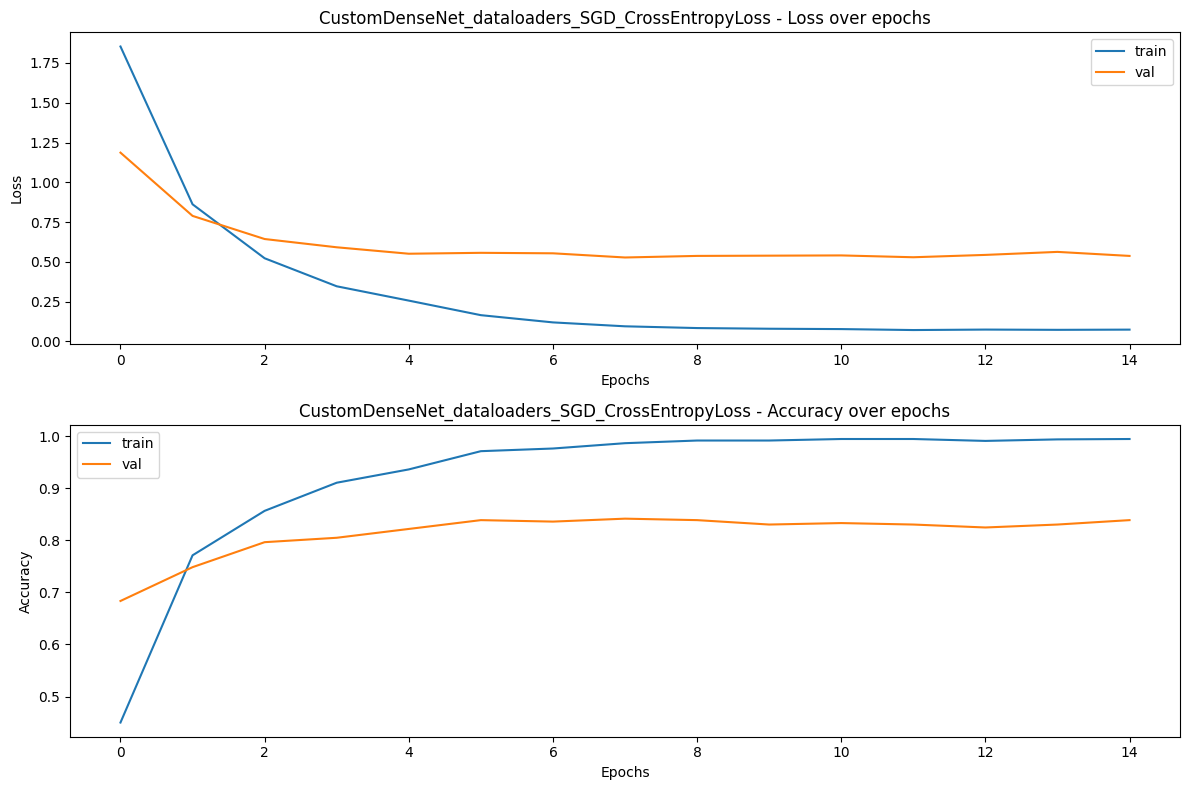


Training with CustomDenseNet, dataloaders, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.3959 Acc: 0.4624
val Loss: 0.7497 Acc: 0.6638

Epoch 1/14
----------
train Loss: 0.4538 Acc: 0.7838
val Loss: 0.5163 Acc: 0.7542

Epoch 2/14
----------
train Loss: 0.2532 Acc: 0.8714
val Loss: 0.4524 Acc: 0.7825

Epoch 3/14
----------
train Loss: 0.1691 Acc: 0.9218
val Loss: 0.4325 Acc: 0.7966

Epoch 4/14
----------
train Loss: 0.0937 Acc: 0.9613
val Loss: 0.3735 Acc: 0.8220

Epoch 5/14
----------
train Loss: 0.0673 Acc: 0.9722
val Loss: 0.3595 Acc: 0.8277

Epoch 6/14
----------
train Loss: 0.0466 Acc: 0.9847
val Loss: 0.3690 Acc: 0.8249

Epoch 7/14
----------
train Loss: 0.0330 Acc: 0.9942
val Loss: 0.3643 Acc: 0.8249

Epoch 8/14
----------
train Loss: 0.0326 Acc: 0.9934
val Loss: 0.3653 Acc: 0.8305

Epoch 9/14
----------
train Loss: 0.0315 Acc: 0.9920
val Loss: 0.3753 Acc: 0.8107

Epoch 10/14
----------
train Loss: 0.0293 Acc: 0.9934
val Loss: 0.3806 Acc: 0.8249

Epoch 11/14
----------
trai

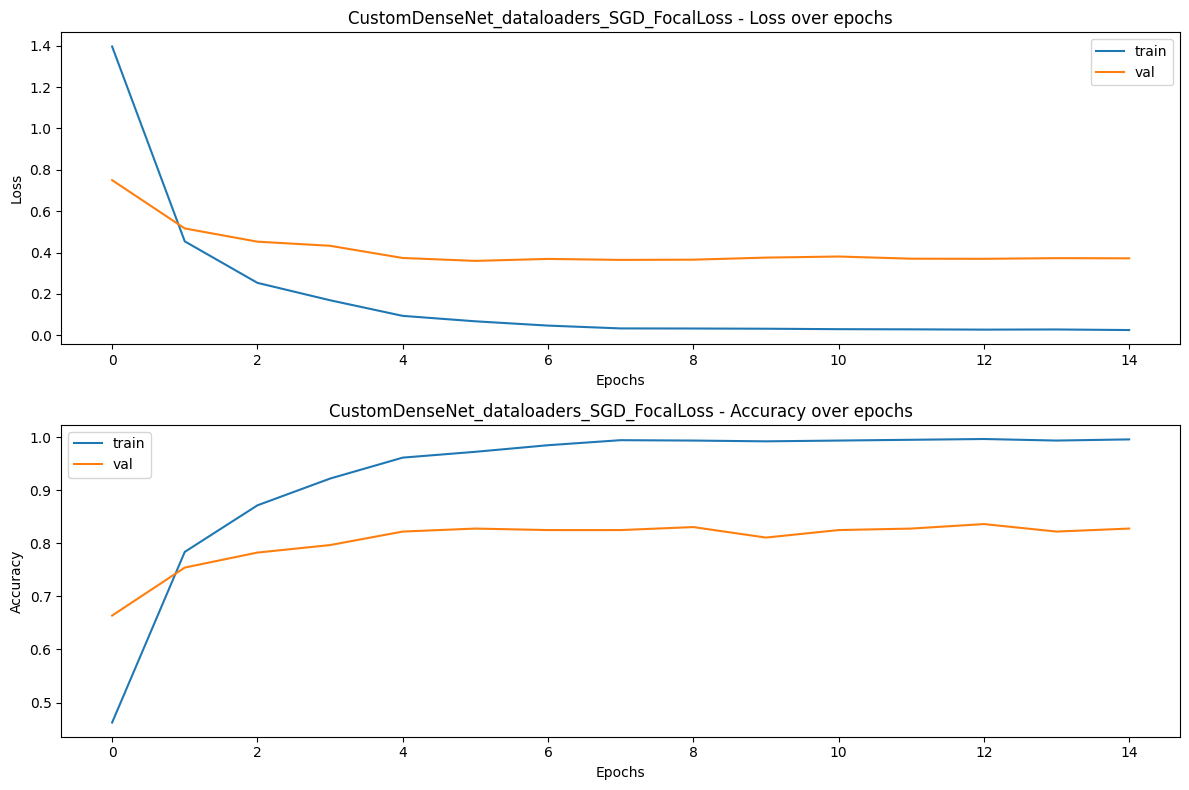


Training with CustomDenseNet, dataloaders, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.2395 Acc: 0.6114
val Loss: 1.2156 Acc: 0.6525

Epoch 1/14
----------
train Loss: 0.7749 Acc: 0.7546
val Loss: 0.9350 Acc: 0.7147

Epoch 2/14
----------
train Loss: 0.5374 Acc: 0.8196
val Loss: 1.0677 Acc: 0.6949

Epoch 3/14
----------
train Loss: 0.4838 Acc: 0.8415
val Loss: 2.8811 Acc: 0.4915

Epoch 4/14
----------
train Loss: 0.4224 Acc: 0.8481
val Loss: 0.9745 Acc: 0.6977

Epoch 5/14
----------
train Loss: 0.3378 Acc: 0.8795
val Loss: 0.9314 Acc: 0.7514

Epoch 6/14
----------
train Loss: 0.2588 Acc: 0.9138
val Loss: 0.6746 Acc: 0.8136

Epoch 7/14
----------
train Loss: 0.1312 Acc: 0.9554
val Loss: 0.4573 Acc: 0.8588

Epoch 8/14
----------
train Loss: 0.0795 Acc: 0.9810
val Loss: 0.4170 Acc: 0.8757

Epoch 9/14
----------
train Loss: 0.0665 Acc: 0.9861
val Loss: 0.4248 Acc: 0.8644

Epoch 10/14
----------
train Loss: 0.0571 Acc: 0.9861
val Loss: 0.4309 Acc: 0.8588

Epoch 11/14
-------

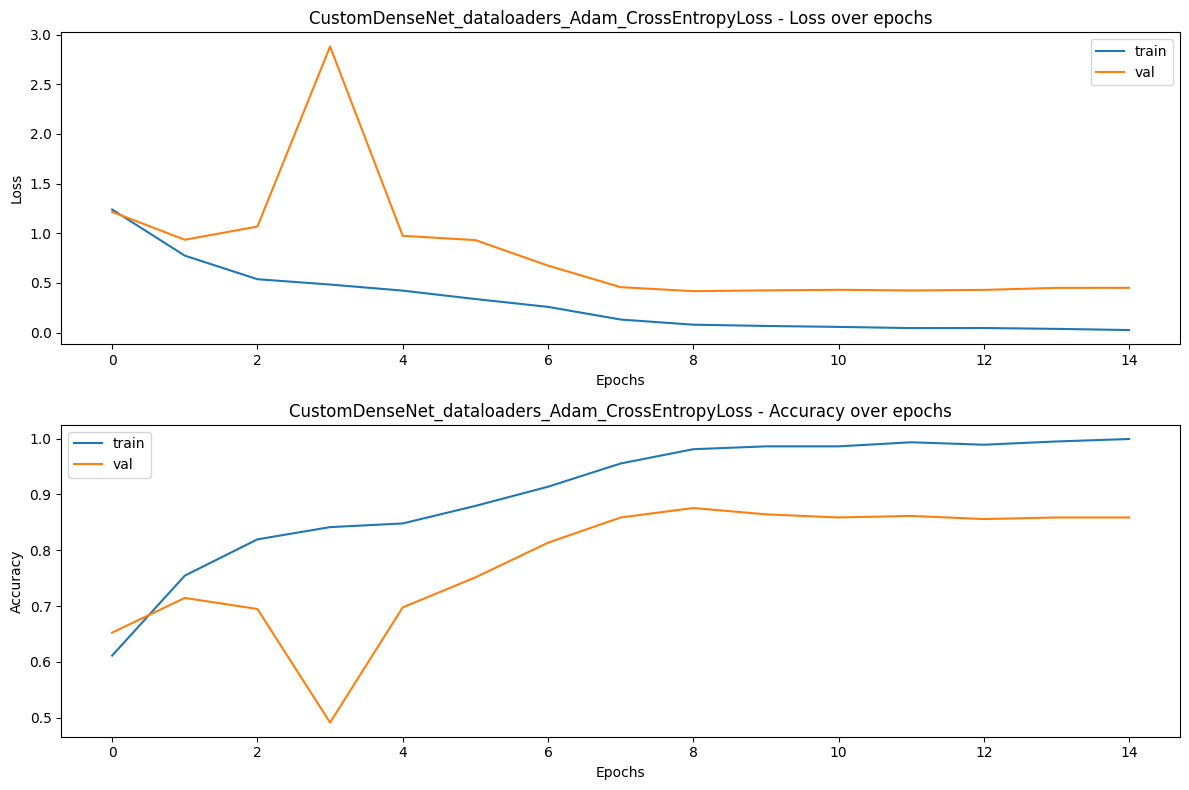


Training with CustomDenseNet, dataloaders, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 0.9045 Acc: 0.6077
val Loss: 0.8756 Acc: 0.6017

Epoch 1/14
----------
train Loss: 0.4755 Acc: 0.7575
val Loss: 0.9752 Acc: 0.6102

Epoch 2/14
----------
train Loss: 0.3930 Acc: 0.7736
val Loss: 0.8330 Acc: 0.6610

Epoch 3/14
----------
train Loss: 0.2937 Acc: 0.8086
val Loss: 0.6836 Acc: 0.6751

Epoch 4/14
----------
train Loss: 0.2286 Acc: 0.8495
val Loss: 0.4227 Acc: 0.7768

Epoch 5/14
----------
train Loss: 0.1664 Acc: 0.8809
val Loss: 0.4308 Acc: 0.7740

Epoch 6/14
----------
train Loss: 0.1642 Acc: 0.8882
val Loss: 0.5553 Acc: 0.6977

Epoch 7/14
----------
train Loss: 0.0764 Acc: 0.9416
val Loss: 0.3222 Acc: 0.8390

Epoch 8/14
----------
train Loss: 0.0422 Acc: 0.9671
val Loss: 0.2795 Acc: 0.8644

Epoch 9/14
----------
train Loss: 0.0270 Acc: 0.9781
val Loss: 0.3238 Acc: 0.8475

Epoch 10/14
----------
train Loss: 0.0266 Acc: 0.9795
val Loss: 0.3101 Acc: 0.8446

Epoch 11/14
----------
tra

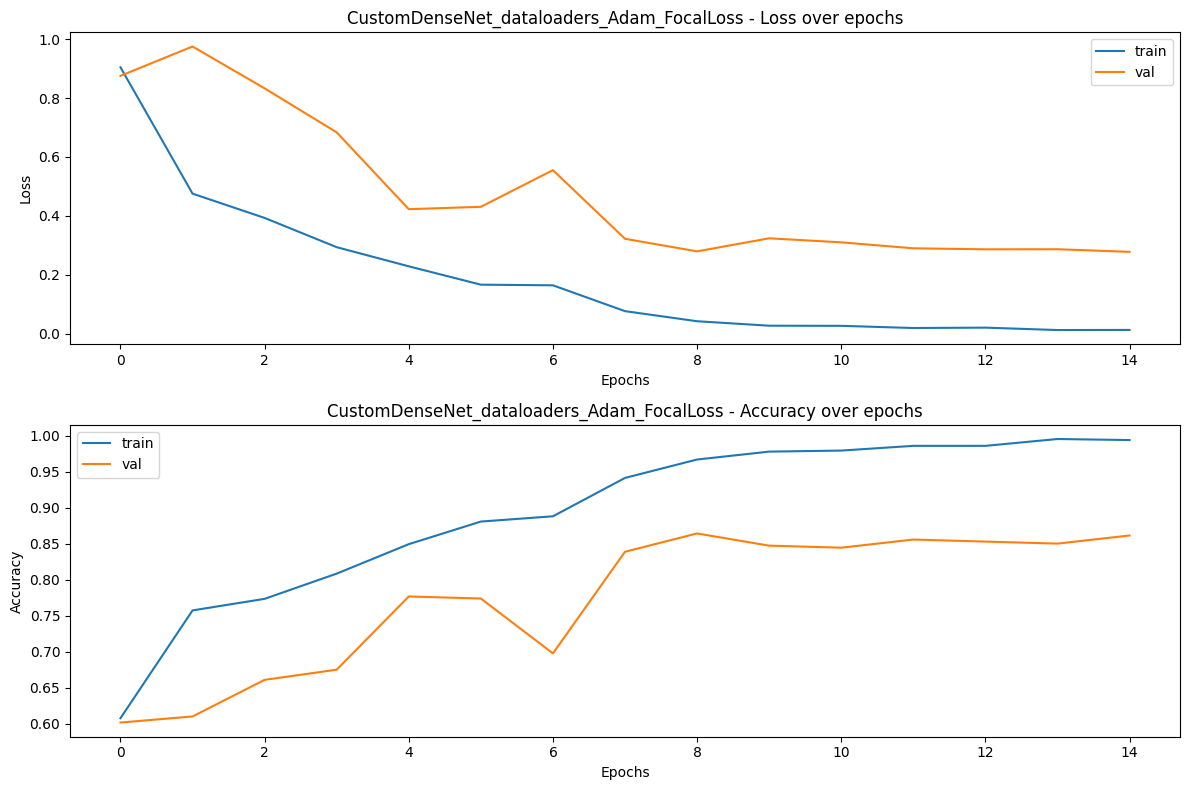


Training with CustomDenseNet, dataloaders2, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9492 Acc: 0.4251
val Loss: 1.3110 Acc: 0.6186

Epoch 1/14
----------
train Loss: 0.9718 Acc: 0.7159
val Loss: 0.9333 Acc: 0.7062

Epoch 2/14
----------
train Loss: 0.6572 Acc: 0.8115
val Loss: 0.7009 Acc: 0.7881

Epoch 3/14
----------
train Loss: 0.4712 Acc: 0.8722
val Loss: 0.6315 Acc: 0.8107

Epoch 4/14
----------
train Loss: 0.3587 Acc: 0.9014
val Loss: 0.6248 Acc: 0.8107

Epoch 5/14
----------
train Loss: 0.2681 Acc: 0.9284
val Loss: 0.5253 Acc: 0.8446

Epoch 6/14
----------
train Loss: 0.2148 Acc: 0.9518
val Loss: 0.5431 Acc: 0.8079

Epoch 7/14
----------
train Loss: 0.1614 Acc: 0.9671
val Loss: 0.5321 Acc: 0.8249

Epoch 8/14
----------
train Loss: 0.1508 Acc: 0.9686
val Loss: 0.5148 Acc: 0.8362

Epoch 9/14
----------
train Loss: 0.1607 Acc: 0.9701
val Loss: 0.5229 Acc: 0.8418

Epoch 10/14
----------
train Loss: 0.1478 Acc: 0.9737
val Loss: 0.5257 Acc: 0.8362

Epoch 11/14
-------

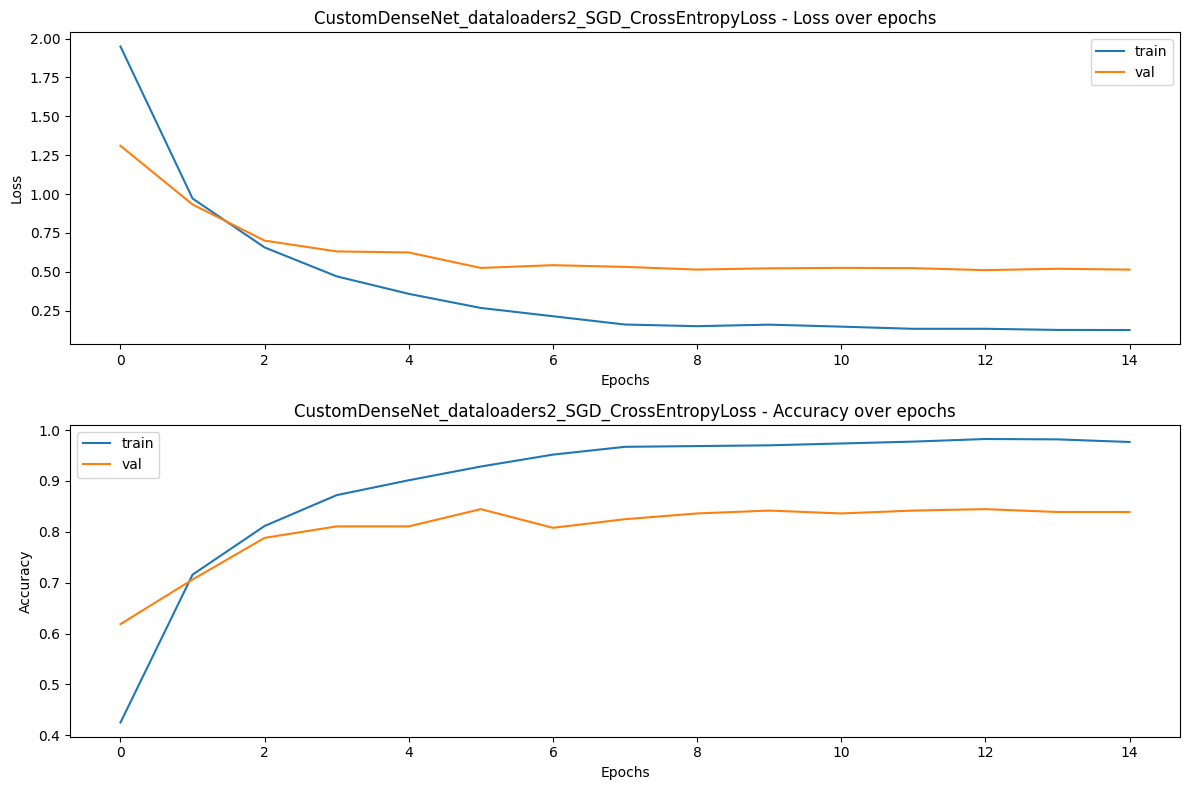


Training with CustomDenseNet, dataloaders2, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4322 Acc: 0.4492
val Loss: 0.7966 Acc: 0.6808

Epoch 1/14
----------
train Loss: 0.5425 Acc: 0.7568
val Loss: 0.5286 Acc: 0.7288

Epoch 2/14
----------
train Loss: 0.3459 Acc: 0.8203
val Loss: 0.4913 Acc: 0.7458

Epoch 3/14
----------
train Loss: 0.2297 Acc: 0.8773
val Loss: 0.3881 Acc: 0.7938

Epoch 4/14
----------
train Loss: 0.1617 Acc: 0.9109
val Loss: 0.3786 Acc: 0.8164

Epoch 5/14
----------
train Loss: 0.1267 Acc: 0.9328
val Loss: 0.3652 Acc: 0.8023

Epoch 6/14
----------
train Loss: 0.0851 Acc: 0.9496
val Loss: 0.3393 Acc: 0.8051

Epoch 7/14
----------
train Loss: 0.0618 Acc: 0.9722
val Loss: 0.3320 Acc: 0.8220

Epoch 8/14
----------
train Loss: 0.0576 Acc: 0.9781
val Loss: 0.3476 Acc: 0.8220

Epoch 9/14
----------
train Loss: 0.0591 Acc: 0.9803
val Loss: 0.3341 Acc: 0.8164

Epoch 10/14
----------
train Loss: 0.0546 Acc: 0.9774
val Loss: 0.3389 Acc: 0.8164

Epoch 11/14
----------
tra

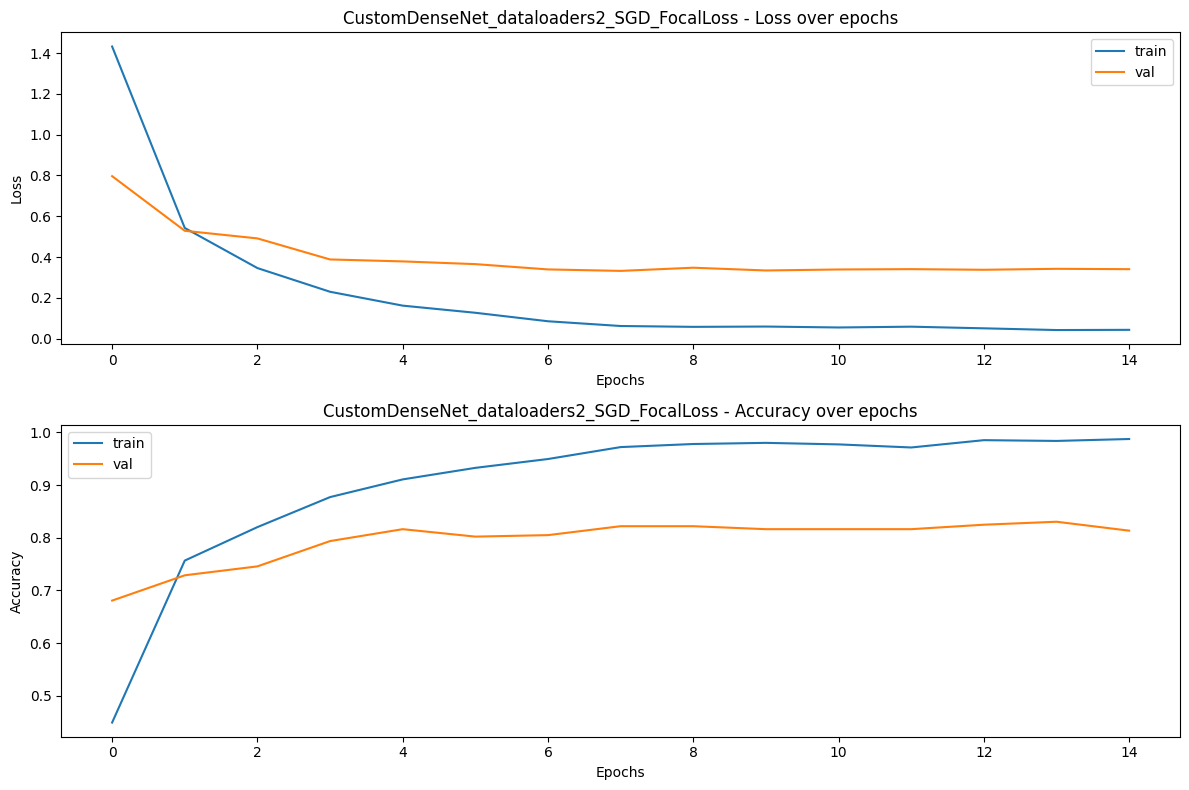


Training with CustomDenseNet, dataloaders2, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.4217 Acc: 0.5522
val Loss: 1.6793 Acc: 0.5734

Epoch 1/14
----------
train Loss: 0.9258 Acc: 0.7064
val Loss: 1.7016 Acc: 0.5621

Epoch 2/14
----------
train Loss: 0.7577 Acc: 0.7524
val Loss: 0.9052 Acc: 0.7429

Epoch 3/14
----------
train Loss: 0.5973 Acc: 0.8020
val Loss: 0.8762 Acc: 0.7316

Epoch 4/14
----------
train Loss: 0.5383 Acc: 0.8115
val Loss: 0.7379 Acc: 0.7655

Epoch 5/14
----------
train Loss: 0.4688 Acc: 0.8408
val Loss: 0.7728 Acc: 0.7542

Epoch 6/14
----------
train Loss: 0.3900 Acc: 0.8671
val Loss: 0.7390 Acc: 0.7881

Epoch 7/14
----------
train Loss: 0.2232 Acc: 0.9262
val Loss: 0.4878 Acc: 0.8390

Epoch 8/14
----------
train Loss: 0.1519 Acc: 0.9591
val Loss: 0.4467 Acc: 0.8531

Epoch 9/14
----------
train Loss: 0.1212 Acc: 0.9693
val Loss: 0.4618 Acc: 0.8503

Epoch 10/14
----------
train Loss: 0.1003 Acc: 0.9730
val Loss: 0.4781 Acc: 0.8559

Epoch 11/14
------

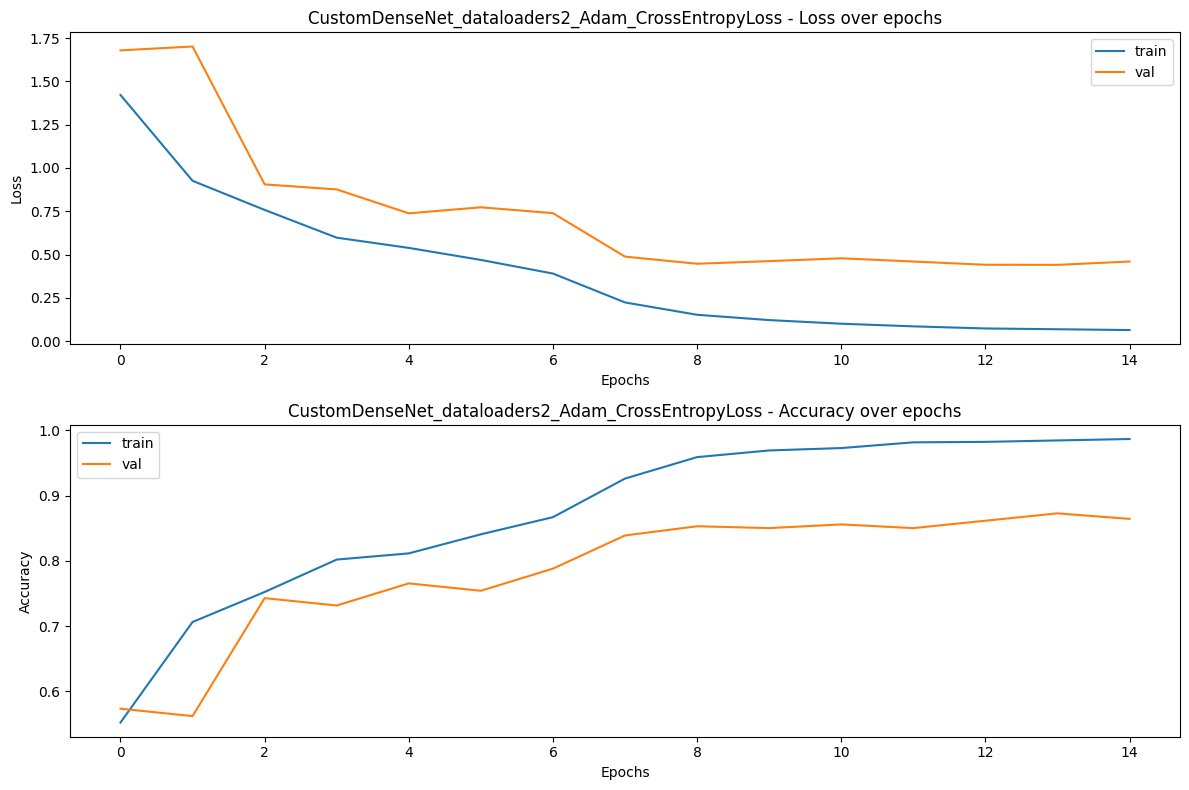


Training with CustomDenseNet, dataloaders2, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0720 Acc: 0.5362
val Loss: 1.0824 Acc: 0.5537

Epoch 1/14
----------
train Loss: 0.5646 Acc: 0.7159
val Loss: 0.8291 Acc: 0.6299

Epoch 2/14
----------
train Loss: 0.4129 Acc: 0.7743
val Loss: 0.7909 Acc: 0.6299

Epoch 3/14
----------
train Loss: 0.3350 Acc: 0.8050
val Loss: 0.6927 Acc: 0.6667

Epoch 4/14
----------
train Loss: 0.3021 Acc: 0.8101
val Loss: 0.5369 Acc: 0.7655

Epoch 5/14
----------
train Loss: 0.2635 Acc: 0.8356
val Loss: 0.5685 Acc: 0.7599

Epoch 6/14
----------
train Loss: 0.2075 Acc: 0.8510
val Loss: 0.8658 Acc: 0.7232

Epoch 7/14
----------
train Loss: 0.1440 Acc: 0.9094
val Loss: 0.3111 Acc: 0.8446

Epoch 8/14
----------
train Loss: 0.0793 Acc: 0.9350
val Loss: 0.3105 Acc: 0.8616

Epoch 9/14
----------
train Loss: 0.0505 Acc: 0.9649
val Loss: 0.2912 Acc: 0.8644

Epoch 10/14
----------
train Loss: 0.0404 Acc: 0.9606
val Loss: 0.3072 Acc: 0.8701

Epoch 11/14
----------
tr

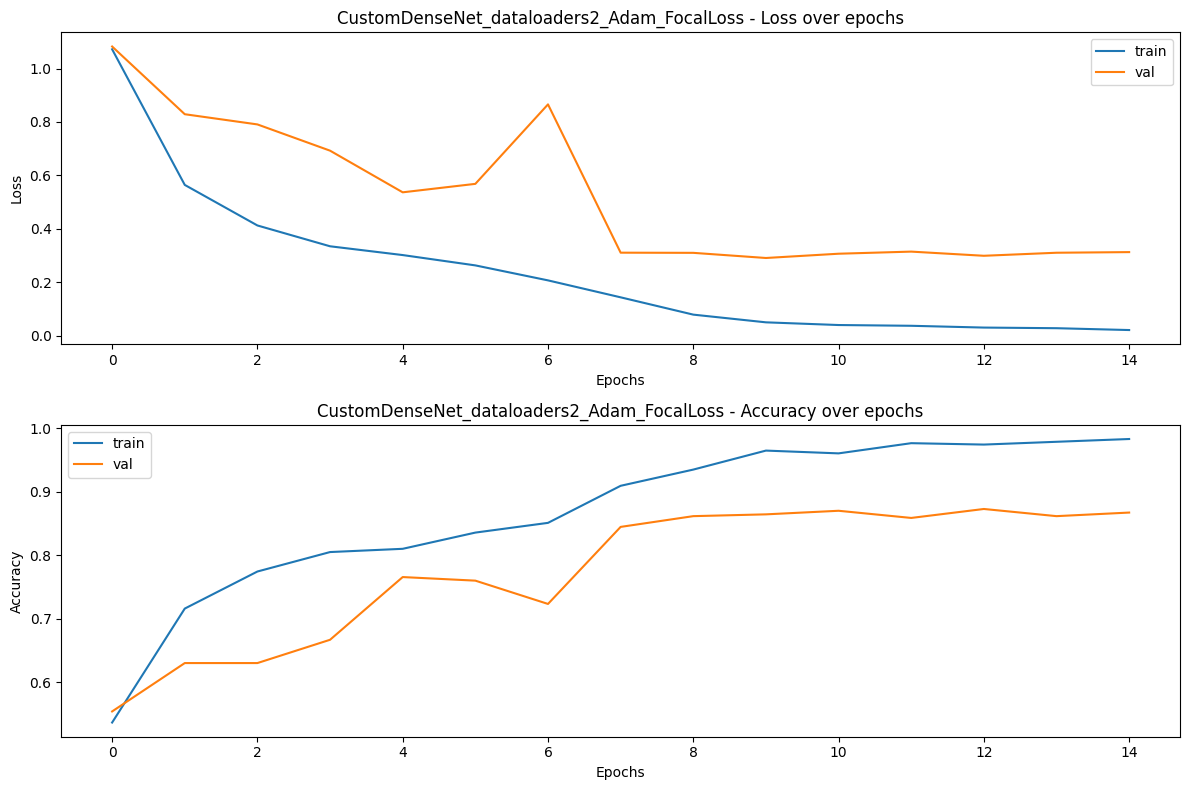


Training with CustomDenseNet, dataloaders3, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.8979 Acc: 0.4339
val Loss: 1.1614 Acc: 0.6497

Epoch 1/14
----------
train Loss: 0.9290 Acc: 0.7348
val Loss: 0.8470 Acc: 0.7316

Epoch 2/14
----------
train Loss: 0.6173 Acc: 0.8093
val Loss: 0.6821 Acc: 0.7910

Epoch 3/14
----------
train Loss: 0.4429 Acc: 0.8766
val Loss: 0.6542 Acc: 0.7825

Epoch 4/14
----------
train Loss: 0.3563 Acc: 0.9007
val Loss: 0.5941 Acc: 0.8249

Epoch 5/14
----------
train Loss: 0.2696 Acc: 0.9262
val Loss: 0.5507 Acc: 0.8390

Epoch 6/14
----------
train Loss: 0.2064 Acc: 0.9511
val Loss: 0.5382 Acc: 0.8362

Epoch 7/14
----------
train Loss: 0.1482 Acc: 0.9708
val Loss: 0.5190 Acc: 0.8503

Epoch 8/14
----------
train Loss: 0.1352 Acc: 0.9759
val Loss: 0.5428 Acc: 0.8333

Epoch 9/14
----------
train Loss: 0.1296 Acc: 0.9774
val Loss: 0.5282 Acc: 0.8446

Epoch 10/14
----------
train Loss: 0.1358 Acc: 0.9825
val Loss: 0.5330 Acc: 0.8503

Epoch 11/14
-------

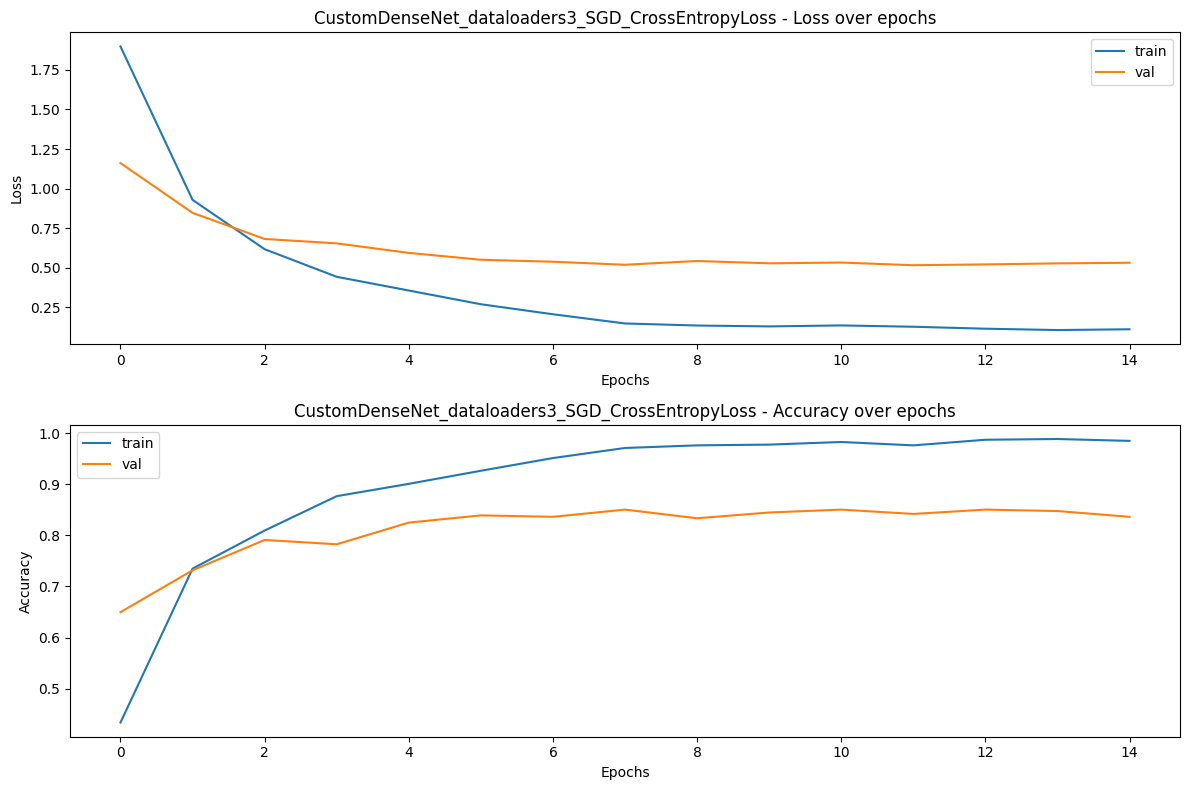


Training with CustomDenseNet, dataloaders3, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4179 Acc: 0.4551
val Loss: 0.7410 Acc: 0.6723

Epoch 1/14
----------
train Loss: 0.5530 Acc: 0.7473
val Loss: 0.5172 Acc: 0.7232

Epoch 2/14
----------
train Loss: 0.3430 Acc: 0.8262
val Loss: 0.4407 Acc: 0.7825

Epoch 3/14
----------
train Loss: 0.2171 Acc: 0.8897
val Loss: 0.3709 Acc: 0.7938

Epoch 4/14
----------
train Loss: 0.1403 Acc: 0.9218
val Loss: 0.3828 Acc: 0.7881

Epoch 5/14
----------
train Loss: 0.1116 Acc: 0.9430
val Loss: 0.3524 Acc: 0.8220

Epoch 6/14
----------
train Loss: 0.0764 Acc: 0.9627
val Loss: 0.3242 Acc: 0.8390

Epoch 7/14
----------
train Loss: 0.0619 Acc: 0.9744
val Loss: 0.3224 Acc: 0.8418

Epoch 8/14
----------
train Loss: 0.0563 Acc: 0.9788
val Loss: 0.3372 Acc: 0.8249

Epoch 9/14
----------
train Loss: 0.0495 Acc: 0.9817
val Loss: 0.3216 Acc: 0.8333

Epoch 10/14
----------
train Loss: 0.0471 Acc: 0.9854
val Loss: 0.3149 Acc: 0.8362

Epoch 11/14
----------
tra

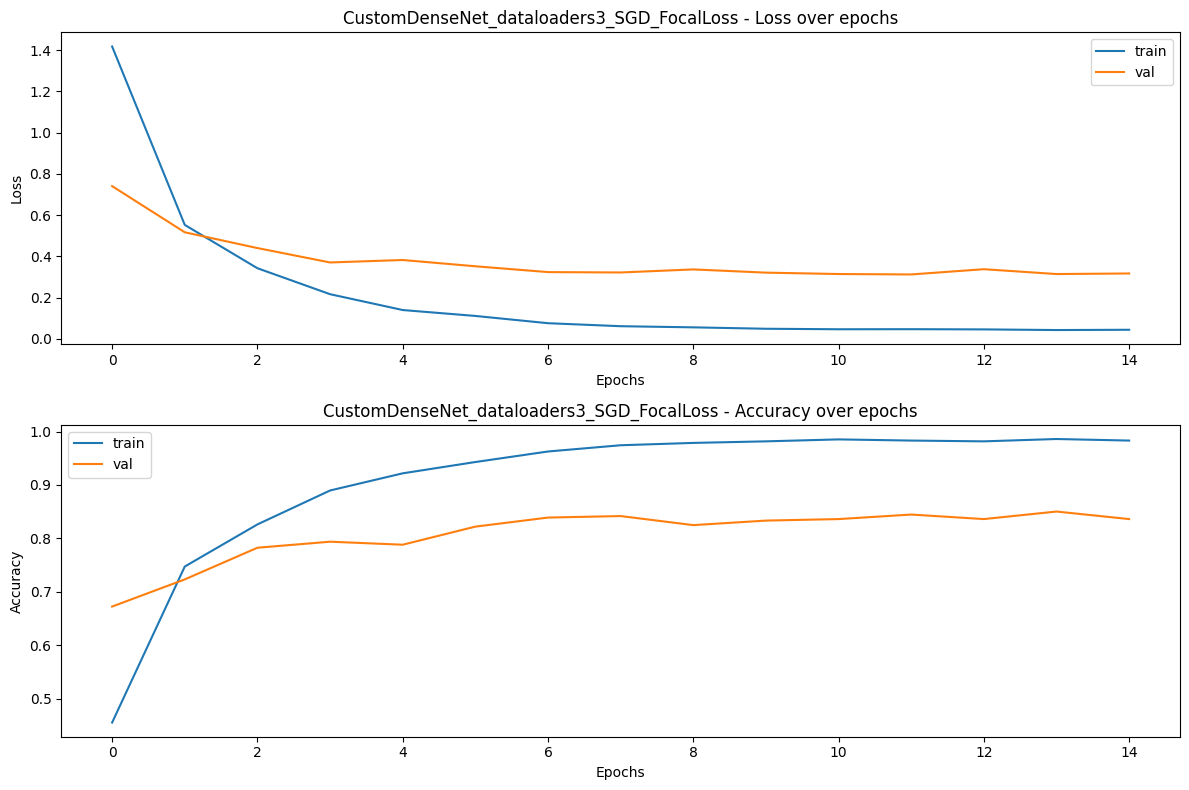


Training with CustomDenseNet, dataloaders3, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.3433 Acc: 0.5946
val Loss: 1.2371 Acc: 0.6073

Epoch 1/14
----------
train Loss: 0.9262 Acc: 0.7034
val Loss: 1.0983 Acc: 0.6469

Epoch 2/14
----------
train Loss: 0.6733 Acc: 0.7663
val Loss: 1.1941 Acc: 0.6073

Epoch 3/14
----------
train Loss: 0.5301 Acc: 0.8210
val Loss: 1.3865 Acc: 0.6780

Epoch 4/14
----------
train Loss: 0.4761 Acc: 0.8444
val Loss: 0.9489 Acc: 0.7627

Epoch 5/14
----------
train Loss: 0.3638 Acc: 0.8817
val Loss: 0.7322 Acc: 0.7627

Epoch 6/14
----------
train Loss: 0.3457 Acc: 0.8904
val Loss: 0.8132 Acc: 0.7627

Epoch 7/14
----------
train Loss: 0.2087 Acc: 0.9299
val Loss: 0.4867 Acc: 0.8475

Epoch 8/14
----------
train Loss: 0.1262 Acc: 0.9620
val Loss: 0.4916 Acc: 0.8446

Epoch 9/14
----------
train Loss: 0.1052 Acc: 0.9693
val Loss: 0.4855 Acc: 0.8475

Epoch 10/14
----------
train Loss: 0.0874 Acc: 0.9795
val Loss: 0.4724 Acc: 0.8475

Epoch 11/14
------

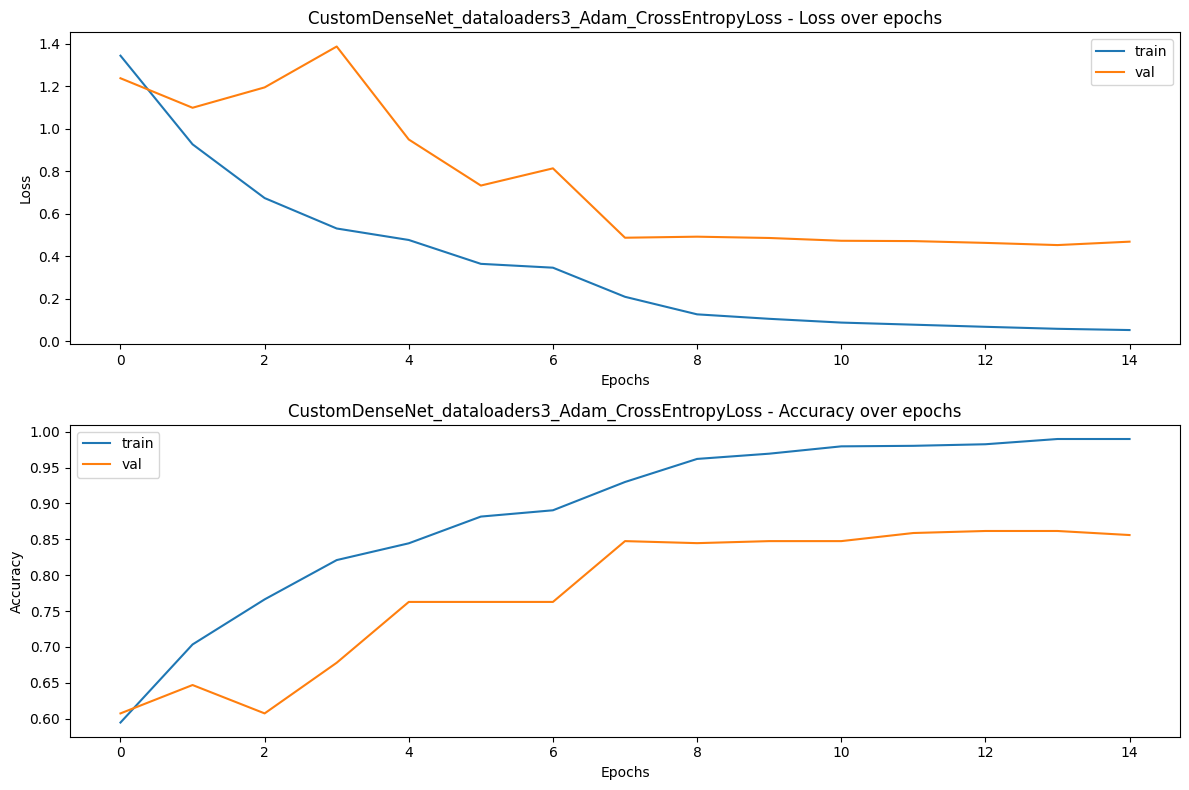


Training with CustomDenseNet, dataloaders3, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0964 Acc: 0.5237
val Loss: 1.0135 Acc: 0.5960

Epoch 1/14
----------
train Loss: 0.5989 Acc: 0.7034
val Loss: 0.8947 Acc: 0.5621

Epoch 2/14
----------
train Loss: 0.4239 Acc: 0.7677
val Loss: 0.8549 Acc: 0.7062

Epoch 3/14
----------
train Loss: 0.3826 Acc: 0.7809
val Loss: 0.6409 Acc: 0.6921

Epoch 4/14
----------
train Loss: 0.2851 Acc: 0.8167
val Loss: 0.6213 Acc: 0.7090

Epoch 5/14
----------
train Loss: 0.2590 Acc: 0.8232
val Loss: 0.5316 Acc: 0.7401

Epoch 6/14
----------
train Loss: 0.2102 Acc: 0.8554
val Loss: 0.7447 Acc: 0.7034

Epoch 7/14
----------
train Loss: 0.1287 Acc: 0.9072
val Loss: 0.3355 Acc: 0.8362

Epoch 8/14
----------
train Loss: 0.0702 Acc: 0.9423
val Loss: 0.2647 Acc: 0.8616

Epoch 9/14
----------
train Loss: 0.0507 Acc: 0.9620
val Loss: 0.2825 Acc: 0.8503

Epoch 10/14
----------
train Loss: 0.0386 Acc: 0.9744
val Loss: 0.2688 Acc: 0.8616

Epoch 11/14
----------
tr

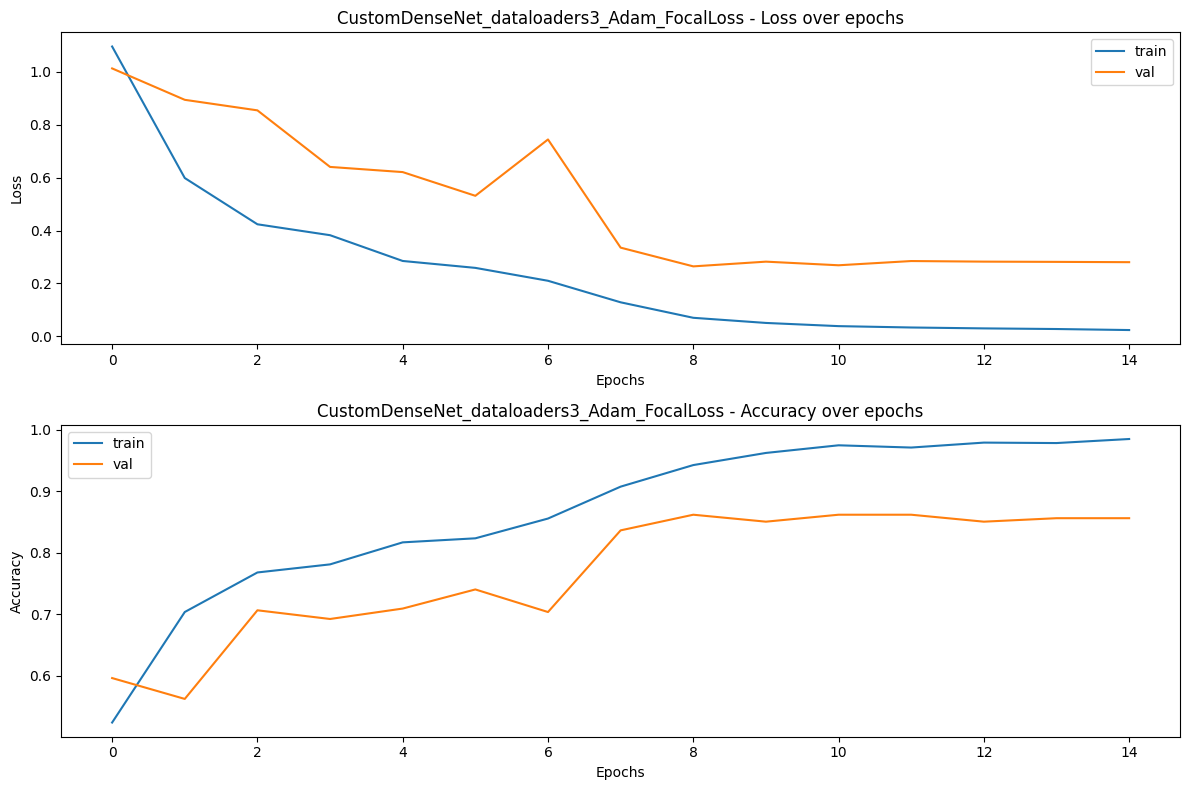

In [10]:
# perform several training runs to compare accuracy on the validation dataset
best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_accuracy = best_val_accuracy
               

In [11]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):
   

    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)
  
    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    
    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("/content/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           2       0.95      0.84      0.89        49
           6       0.88      1.00      0.93        14
           7       1.00      0.94      0.97        18
           8       0.92      1.00      0.96        35
           9       0.91      0.94      0.93        34
          11       1.00      0.95      0.97        20
          12       0.00      0.00      0.00        12
          13       1.00      0.33      0.50         3
          14       0.95      1.00      0.97        19
          16       0.52      0.80      0.63        20
          17       0.94      0.94      0.94        17
          18       0.91      0.95      0.93        22
          19       1.00      0.89      0.94        19
          23       0.53      0.53      0.53        19
          25       0.85   

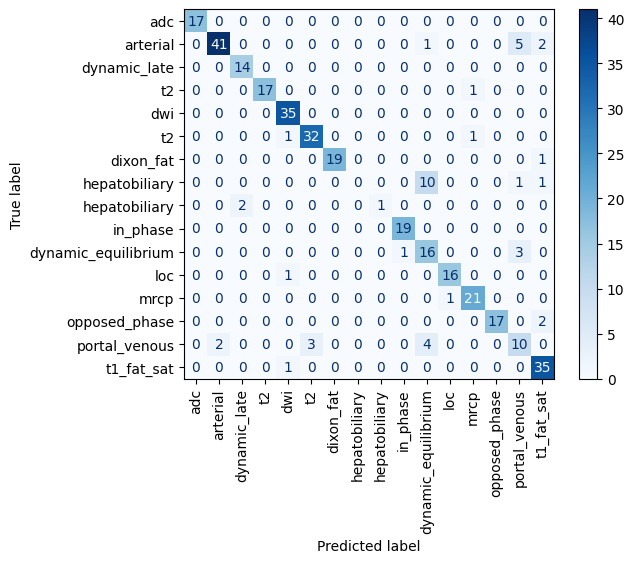

<Figure size 2500x2500 with 0 Axes>

In [12]:
# Evaluate the model on the val dataset
model = best_model

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(val_predictions, val_labels, classes, fn='DenseNetFL', saveflag=True)

# Save the trained model if needed
save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
torch.save(trained_model.state_dict(), '/content/gdrive/MyDrive/model0530b.pth')



# model.eval()
# val_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(labels)
#     with torch.no_grad(): # No need to calculate gradients when doing inference
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1) # Get class from network's prediction
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# print (test_predictions)
# print(test_labels)


# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)


# accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
# print('Accuracy on the test dataset is ', np.round(accuracy, 3))
# #results = make_results_df(preds, true, test)

# # Save the trained model if needed
# save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
# torch.save(trained_model.state_dict(), save_filename)


[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.88      0.92      0.90        61
           6       0.85      1.00      0.92        17
           7       1.00      1.00      1.00        22
           8       0.96      1.00      0.98        43
           9       1.00      0.95      0.98        42
          11       1.00      1.00      1.00        29
          12       0.25      0.10      0.14        10
          13       0.00      0.00      0.00         3
          14       1.00      1.00      1.00        23
          16       0.64      0.64      0.64        22
          17       1.00      0.95      0.98        21
          18       1.00      1.00      1.00        28
          19       1.00      1.00      1.00        23
          23       0.52      0.70      0.60        20
          25       0.98   

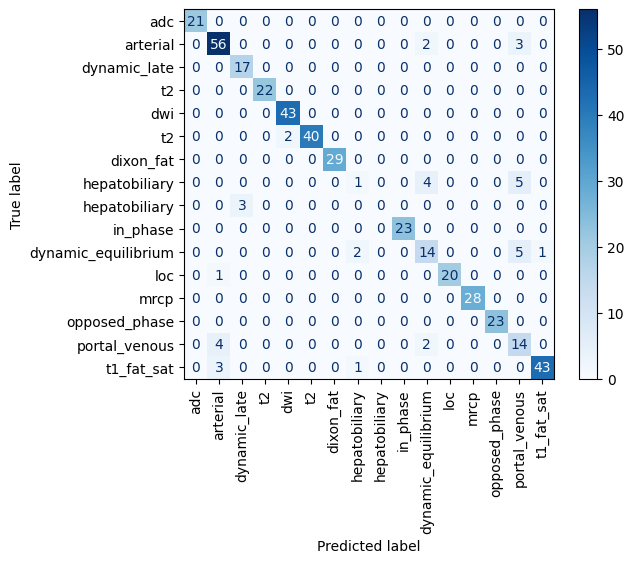

<Figure size 2500x2500 with 0 Axes>

In [13]:
# Evaluate the model on the test dataset
model = best_model

model.eval()
test_predictions = []
test_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        test_predictions.append(predicted.cpu().numpy())
        test_labels.append(labels.cpu().numpy())
test_predictions = np.concatenate(test_predictions, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(test_predictions, test_labels, classes, fn='DenseNetFL', saveflag=True)

# Save the trained model if needed
save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
torch.save(trained_model.state_dict(), '/content/gdrive/MyDrive/model0530b.pth')



# model.eval()
# val_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(labels)
#     with torch.no_grad(): # No need to calculate gradients when doing inference
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1) # Get class from network's prediction
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# print (test_predictions)
# print(test_labels)


# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)


# accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
# print('Accuracy on the test dataset is ', np.round(accuracy, 3))
# #results = make_results_df(preds, true, test)

# # Save the trained model if needed
# save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
# torch.save(trained_model.state_dict(), save_filename)


In [14]:
torch.save(trained_model.state_dict(), '/content/model0531a.pth')


In [15]:
!pip install transformers
from transformers import DeiTFeatureExtractor, DeiTForImageClassification



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
batch_size = 16

optimizer = optim.Adam(deit_model.parameters(), lr=0.001, betas=(0.9,0.99))
criterion = FocalLoss()


def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    if min_val != max_val:
        image = (image - min_val) / (max_val - min_val)
    else:
        # Avoid zero division and return a zero image.
        image = torch.zeros_like(image)
    return image

class ImgDataset_deit(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
        
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
      source = file_dict['img_data_dir_local']
      dest = file_dict['img_data_dir_colab']

      img_file = self.data_df.fname[idx]
      ds = pydicom.dcmread(img_file)
      img = ds.pixel_array.astype(np.float32)  # Convert to float
      img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize here
      print('img min:', np.min(img), 'img max:', np.max(img))
      img = torch.from_numpy(img)  # Convert to torch tensor
      img = img.repeat(3, 1, 1)  # Convert to 3-channel image

      if self.transform:
        img = self.transform(img)

      img = img[np.newaxis]
      # Apply feature extractor directly here
      img = feature_extractor(images=img, return_tensors="pt")["pixel_values"]
      print('now img min is ', np.min(img), 'img max is ', np.max(img))

      labl = self.data_df.label[idx]
      adjusted_label = classes.index(labl)
      y = torch.tensor(adjusted_label, dtype=torch.long) 

      return (img, y)



deit_transforms = {
    'train': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
]),
    'val': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ]),

    'test': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ])
}

def get_data_loaders_deit(train, val, test, batch_size, data_transforms = deit_transforms, shuffle=True, num_workers=0):
    # Create instances of your custom dataset
    train_imgdata = ImgDataset_deit(train, data_transforms['train'])
    val_imgdata = ImgDataset_deit(val, data_transforms['val'])
    test_imgdata = ImgDataset_deit(test, data_transforms['test'])

    # Create data loaders for the training, validation, and test datasets
    train_loader = DataLoader(train_imgdata, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_imgdata, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader = DataLoader(test_imgdata, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataset_sizes = {'train': len(train_imgdata), 'val': len(val_imgdata)}

    return train_loader, val_loader, test_loader, dataset_sizes








train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=deit_transforms)



Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['cls_classifier.weight', 'cls_classifier.bias', 'distillation_classifier.bias', 'distillation_classifier.weight']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream t

In [17]:
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data)


In [18]:
def train_deit_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.logits, labels)
                    _, preds = torch.max(outputs.logits, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


Epoch 0/24
----------
train Loss: 2.4341 Acc: 0.1549
val Loss: 2.1023 Acc: 0.1949

Epoch 1/24
----------
train Loss: 1.8023 Acc: 0.2652
val Loss: 1.9228 Acc: 0.2316

Epoch 2/24
----------
train Loss: 1.8396 Acc: 0.2425
val Loss: 2.1609 Acc: 0.1751

Epoch 3/24
----------
train Loss: 1.6445 Acc: 0.2681
val Loss: 1.6977 Acc: 0.2825

Epoch 4/24
----------
train Loss: 1.4183 Acc: 0.3565
val Loss: 1.5245 Acc: 0.3249

Epoch 5/24
----------
train Loss: 1.2867 Acc: 0.4003
val Loss: 1.6325 Acc: 0.3051

Epoch 6/24
----------
train Loss: 1.1711 Acc: 0.4259
val Loss: 1.5178 Acc: 0.3983

Epoch 7/24
----------
train Loss: 1.1479 Acc: 0.4456
val Loss: 1.4817 Acc: 0.3672

Epoch 8/24
----------
train Loss: 1.0111 Acc: 0.4806
val Loss: 1.4633 Acc: 0.3446

Epoch 9/24
----------
train Loss: 0.9869 Acc: 0.4901
val Loss: 1.5753 Acc: 0.2938

Epoch 10/24
----------
train Loss: 0.9678 Acc: 0.4755
val Loss: 1.5520 Acc: 0.3616

Epoch 11/24
----------
train Loss: 0.8845 Acc: 0.5252
val Loss: 1.3046 Acc: 0.4181

Ep

TypeError: ignored

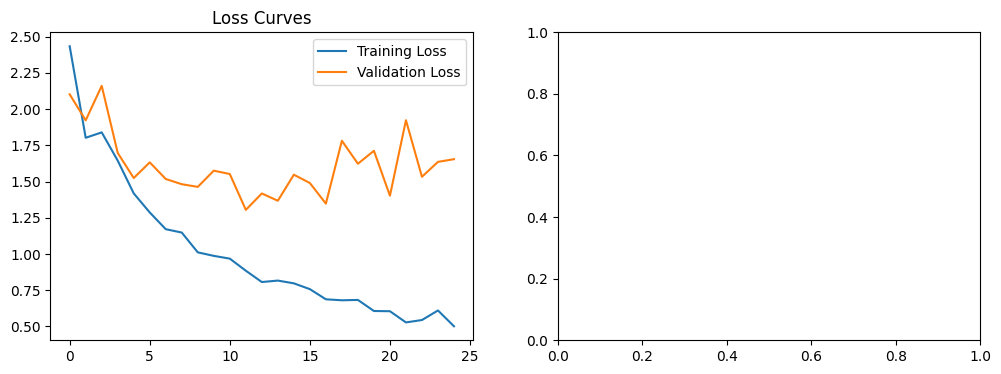

In [19]:
deit_model = deit_model.to(device)
deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, {'train': train_loader_deit, 'val': val_loader_deit}, criterion, optimizer, num_epochs=25)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc.cpu(), label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained DeiT model and adjust the classifier for your number of classes
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
num_classes = len(classes) # classes is your list of classes
deit_model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
deit_model.to(device)

# Define your loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deit_model.parameters(), lr=0.001)

num_epochs = 20

# Start training
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_deit, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = deit_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


In [ ]:
running_loss

In [ ]:
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(test_loader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        labels = labels.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.permute(1,2,0).cpu().numpy() # Permute axes because im.show() expects dims [W,H,C] and PyTorch/NumPy use [C,W,H]
        mean = np.array([0.5])
        std = np.array([0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(idx_to_class[preds[idx]], idx_to_class[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(best_model,test_loader,device)